# QF604 ECONOMETRICS OF FINANCIAL MARKETS

In [88]:
# !pip3 install arch

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.linalg import toeplitz
import statsmodels.formula.api as smf

import datetime as dt
from statsmodels.sandbox.regression.gmm import GMM
from arch import arch_model
from arch.__future__ import reindexing
from statsmodels.tsa.vector_ar.vecm import coint_johansen

### Summary by YU Lingfeng
## <a id = "top">Table of Content</a>

### [Lecture 1. Hedging](#p1)
- ##### [1.1 functions](#p11)
- ##### [1.2 Optimal Hedge Ratio](#p12)

### [Lecture 2.  Event Study](#p2)
- ##### [2.1 functions](#p21)
- ##### [2.2 Results](#p22)
- ##### [2.3 Homework 1](#p23)

### [Lecture 3. Time Series Modeling](#p3)
- ##### [3.1 functions](#p31)
- ##### [3.2 Results](#p32)
- ##### [3.3 Homework 2](#p33)

### [Lecture 4. Multivariate Regression](#p4)
- ##### [4.1 functions](#p41)
- ##### [4.2 Results](#p42)
- ##### [4.3 Homework 3](#p43)

### [Lecture 5. Cross-Section Regression](#p5)
- ##### [5.1 functions](#p51)
- ##### [5.2 Results](#p52)

### [Lecture 6. Euler Equation and Generalized Method of Moments](#p6)
- ##### [6.1 functions](#p61)
- ##### [6.2 Results](#p62)
- ##### [6.3 Homework 4](#p63)

### [Lecture 7. Maximum Likelihood Method and GARCH](#p7)
- ##### [7.1 functions](#p71)
- ##### [7.2 Results](#p72)

### [Lecture 8. Unit Roots and Cointegration](#p8)
- ##### [8.1 functions](#p81)
- ##### [8.2 Results](#p82)

## <a id = "p1"> Lecture 1. </a> Hedging [back to table of contents](#top)

In [90]:
# import statsmodels.api as sm
# import seaborn as sns
# from scipy import stats

1. Form a hedge portfolio comprising V_t = f x S_t

2. and `h` number of short on futures contracts

3. Notional value of futures contract = `500` x F in Yen per contract

4. P_t+1 - P_t = f x (S_t+1 - S_t) - h x 500 x (F_t+1 - F_t)

5. Minimize var(P_t+1 - P_t)

6. h* = cov(S_t+1 - S_t,F_t+1 - F_t) x `f`/`500`

7. Current N225 Index on 1 Sep is 17479.57; suppose portfolio value is 10 billion Yen to be hedged, `f` = 10B/17479.57 

##### <a id = "p11"> </a> 1.1 function definition [back to table of contents](#top)

In [91]:
def optimal_hedge(df, futpr_locN, spotpr_locN, ttm_locN, x_ticks,
                 pct_fee=0.005, div_rate=0.01, rf=0.005, 
                 Notional=1e10, a_const=500, str_name='N225'):
### Assume transactions cost 0.5% (brokerage and exchange fees)
### Assume N225 portfolio aggregate dividend was 1.0% p.a.
### Assume Japanese riskfree rate was 0.5% p.a.    
    
    futpr=df.iloc[:,futpr_locN]
    spotpr=df.iloc[:,spotpr_locN]
    ttm=df.iloc[:,ttm_locN]/365    
    fairpr = [0] * len(df)
    for i in range(len(df)):
        if futpr[i] > spotpr[i]:
            fairpr[i] =\
                (1+2*pct_fee)*\
                (spotpr[i] - div_rate*spotpr[i]*ttm[i]/(1+rf*ttm[i]))*\
                (1+rf*ttm[i])
        else: 
            fairpr[i] =\
                (1-2*pct_fee)*\
                (spotpr[i]- div_rate*spotpr[i]*ttm[i]/(1+rf*ttm[i]))*\
                (1+rf*ttm[i])    
    time = np.array(range(len(df)))
    
#     x_ticks =\
#         [''] * 30
#     x_ticks =\
#         ['Sep 01'] + [''] * 8 +\
#         ['Sep 15'] + [''] * 9 +\
#         ['Oct 01'] + [''] * 9 +\
#         ['Oct 15']    

# Future Price VS Fair Price    
    plt.plot(time, futpr)
    plt.plot(time, fairpr)
    plt.xticks(np.arange(len(time)), 
               x_ticks)
    plt.xlabel('Trading Day')
    plt.ylabel('Futures Price')
    plt.title(f'Prices of {str_name} December Futures \
Contract from 1/9/1999 to 15/10/1999')
    plt.legend(['Futures Price', 'Fair Price'])
    plt.show()
#     spotpr*div_rate*ttm

# Percent Difference between Future Price and Fair Price
    p=(futpr-fairpr)/fairpr
    plt.plot(time, p,color='black')
    plt.xticks(np.arange(len(time)), 
               x_ticks)
    plt.xlabel('Trading Day')
    plt.ylabel('Percent Difference')
    plt.axhline(y = 0.01, color = 'b', linestyle = '--')
    plt.axhline(y = -0.01, color = 'b', linestyle = '--')
    plt.title('Percentage Difference Between Futures Price \
and Fair Price from 1/9/1999 to 15/10/1999')
    plt.legend(['% Difference'])
    plt.show()

    
# Plot of Residuals    
    Y=np.log(futpr/fairpr)    
    dY=(Y-Y.shift(1)).dropna()
    dY0=dY[1:,]
    dY1=dY.shift(1).dropna()   ### dY1 is lagged one period dY0    
    y = dY0
    x = dY1
    # defining the variables
    x = x.tolist()
    y = y.tolist()
    # adding the constant term
    x = sm.add_constant(x)
    # performing the regression and fitting the model
    result = sm.OLS(y, x).fit()
    # printing the summary table
    print(result.summary())
    
    print('Parameters: ', result.params[0],result.params[1])
    print('R2: ', result.rsquared)
    print('Adj R2: ', result.rsquared_adj)
    print('SSR: ', result.ssr)
    print('S.E. of Reg: ', np.sqrt(result.mse_resid))
    print('F: ', result.fvalue)
    print('Prob(F): ', result.f_pvalue)    

    mu, std = stats.norm.fit(result.resid)
    mu, std    
    re=result.resid
#     print(re)       
    sns.histplot(result.resid)
    sns.kdeplot(result.resid, color='r', shade=True)
    plt.xlabel("residual")
    plt.ylabel("pdf with histogram")    
    sm.qqplot(result.resid, line='s')
    plt.show()
    
    
### Form a hedge portfolio comprising V_t = f x S_t Yen 
###   (V_t is value of diversified portfolio of Jap stocks, S_t = N225 Index)
###   and h number of short N225 index futures contracts. 
###   Notional value of futures contract = 500 x F in Yen per contract.

### Change in hedged Portfolio Value 
###   P_t+1 - P_t = f x (S_t+1 - S_t) - h x 500 x (F_t+1 - F_t). 
###   Minimize var(P_t+1 - P_t)
### optimal h* = cov(S_t+1 - S_t,F_t+1 - F_t) x f/500
### Current N225 Index on 1 Sep is 17479.57; 
###   suppose portfolio value is 10 billion Yen to be hedged, f = 10B/17479.57 

#     f = round(Notional/17479)
    f = round(Notional/spotpr[0])
#     print(spotpr[0])
    CS=(spotpr-spotpr.shift(1)).dropna()
    CF=(futpr-futpr.shift(1)).dropna()
    time1 = np.array(range(len(CS)))

    plt.plot(time1,CS)
    plt.plot(time1,CF)
    plt.xticks(np.arange(len(time)), 
               x_ticks)
    plt.xlabel('Trading Day')
    plt.ylabel('Change in Price')
    plt.title(f'Change in {str_name} Index and {str_name} Dec \
Futures Price from 1/9/1999 to 15/10/1999')
    plt.legend([str_name+' Index', str_name+' Futures'])
    plt.show()
    
    CF = sm.add_constant(CF)
    result2 = sm.OLS(CS, CF).fit()
    # printing the summary table
    print(result2.summary())
    beta = result2.params[1]
    optimal_h = beta*f/a_const 
    
    return optimal_h

##### <a id = "p12"> </a> 1.2 Optimal Hedge Ratio [back to table of contents](#top)

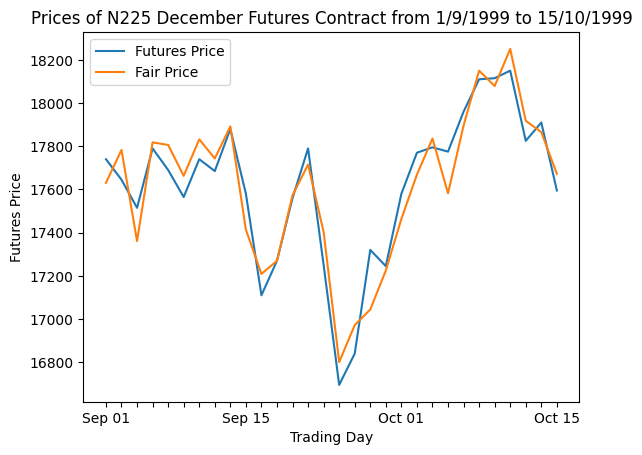

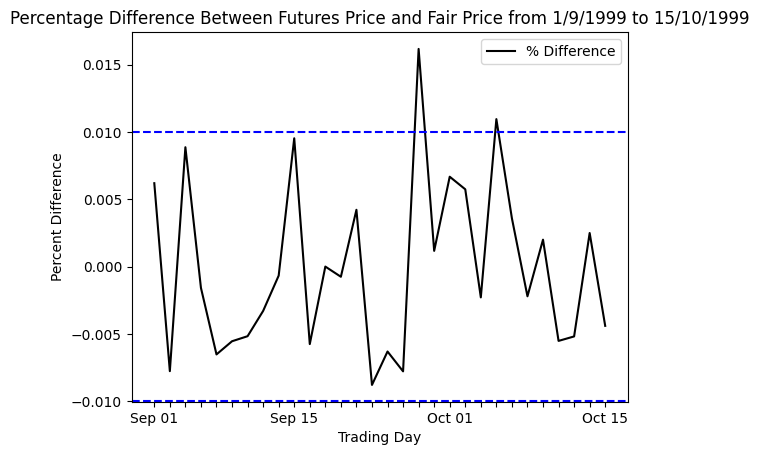

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     13.99
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           0.000916
Time:                        20:34:01   Log-Likelihood:                 97.874
No. Observations:                  28   AIC:                            -191.7
Df Residuals:                      26   BIC:                            -189.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.543e-05      0.001      0.032      0.9

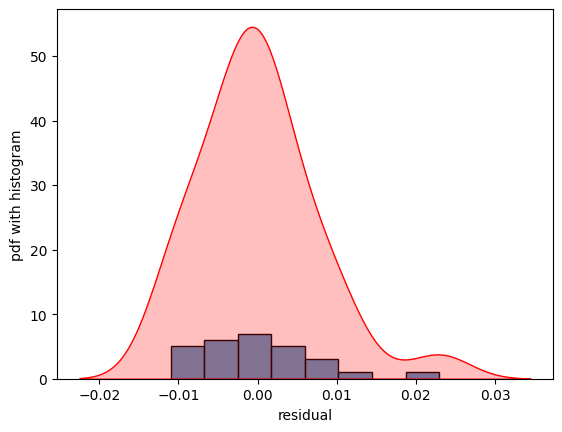

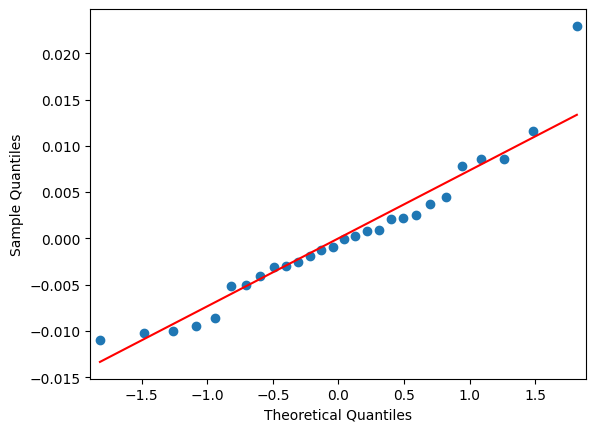

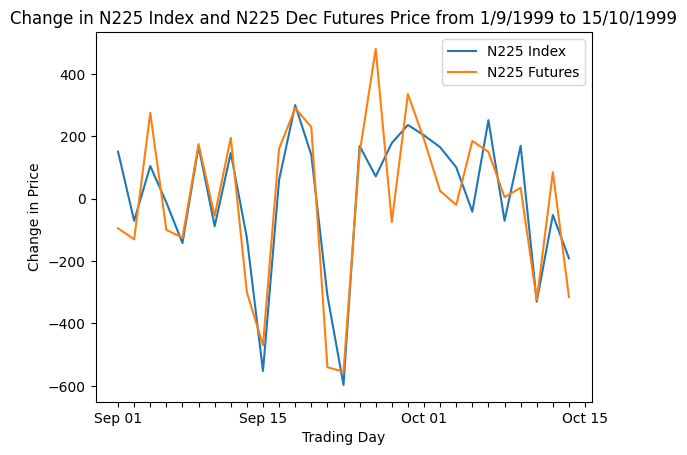

                            OLS Regression Results                            
Dep. Variable:              N225index   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     59.66
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           2.63e-08
Time:                        20:34:01   Log-Likelihood:                -181.12
No. Observations:                  29   AIC:                             366.2
Df Residuals:                      27   BIC:                             369.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6663     24.020      0.194      0.8

818.9558792799708

In [92]:
# def optimal_hedge(df, futpr_locN, spotpr_locN, ttm_locN, x_ticks,
#                  pct_fee=0.005, div_rate=0.01, rf=0.005, 
#                  Notional=1e10, a_const=500, str_name='N225'):

N225 = pd.read_csv('N225.csv')
x_ticks_ =\
        ['Sep 01'] + [''] * 8 +\
        ['Sep 15'] + [''] * 9 +\
        ['Oct 01'] + [''] * 9 +\
        ['Oct 15'] 
hedge_h =\
    optimal_hedge(N225, -2, 0, -1, x_ticks_,
                  pct_fee=0.005, div_rate=0.01, rf=0.005, 
                  Notional=1e10, a_const=500, str_name='N225')
hedge_h

## <a id = "p2"> Lecture 2. </a> Event Study [back to table of contents](#top)

* Using Market Model as Benchmark
* Using Market-Adjusted Return as Benchmark
* Using Mean-Adjusted Return as Benchmark
    

##### <a id = "p21"> </a> 2.1 function definition [back to table of contents](#top)

Data collected do not contain weekend prices that are same as Friday closing. Returns are continuously compounded.

In [93]:
def event_study(df, Target_locN, MktRet_locN, event_iloc, 
                N_pre, N_window=21, str_name='Target Asset'):

    estimation =\
        df.iloc[event_iloc-N_pre:
                event_iloc-N_window//2]
#     print(event_iloc-N_pre, event_iloc-N_window//2)    
    X2 =\
        estimation.iloc[:, MktRet_locN] 
    Y2 =\
        estimation.iloc[:, Target_locN]
    Z2 = sm.add_constant(X2)
    MM_model = sm.OLS(Y2, Z2).fit()
    MM_predictions = MM_model.predict(Z2) 
    MM_results = MM_model.summary()
    print(MM_results)
    event =\
        df.iloc[event_iloc-N_window//2:
                event_iloc+N_window//2+1]
#     print(event_iloc-N_window//2, event_iloc+N_window//2+1)
    X3 =\
        event.iloc[:, MktRet_locN]
    Y3 =\
        event.iloc[:, Target_locN]
    C = MM_model.params
    ### C[0] gives intercept estimate; C[1] gives slope estimate
    ### Compute Abnormal Return AR 
    AR = Y3 - C[0] - C[1]*X3
    ### Compute Cumulative Abnormal Return CAR    
    CAR = AR.cumsum()    
    ### Compute Market Adjusted Return MAR     
    MAR = Y3 - X3
    ### Compute Mean Adjusted Return MeAR
    MeAR=Y3-np.mean(Y2)

    time =\
        range(-(N_window//2),
              N_window-(N_window//2),
              1)  ### range(start, stop, step)
    # plotting the points 
    time =\
        time[:len(AR)]
    plt.plot(time, AR)
    plt.plot(time, CAR)    
    plt.plot(time, MAR)  
    plt.plot(time, MeAR)
    
    plt.xticks(list(time))
    # Add a vertical line at x = 0
    plt.axvline(x=0, color='red', linestyle='--', label='Event Day')

    # naming the x axis
    plt.xlabel(' Event Day')
    # naming the y axis
    plt.ylabel(str_name+' Abnormal Return')
    # giving a title to my graph
    plt.title(str_name + ' Event Study')
    plt.legend([str_name+' AR',
                str_name+' CAR',
                str_name+' MAR',
                str_name+' MeAR'])
    plt.show()

    sigma=np.sqrt(MM_model.mse_resid)
    t_stat_AR=AR/sigma    
    sd=np.sqrt(range(1,N_window+1,1)*(sigma**2))    
    
    sd2=np.std(Y2-X2)
    t_stat_MAR=MAR/sd2
    
    sd3=np.std(Y2-np.mean(Y2))
    t_stat_MeAR=MeAR/sd3

    
    plt.plot(time, t_stat_AR) 
    plt.plot(time, t_stat_MAR)  
    plt.plot(time, t_stat_MeAR)
    plt.xticks(list(time))
    plt.axvline(x=0, color='red', linestyle='--', label='Event Day')

    # naming the x axis
    plt.xlabel(' Event Day')
    # naming the y axis
    plt.ylabel('t-states of Abnormal Return')
    # giving a title to my graph
    plt.title('t-states of ' +str_name+ ' Event Abnormal Return')
    plt.legend([str_name+' AR',
                str_name+' MAR',
                str_name+' MeAR'])
    plt.show()
    
    t_stat =\
        pd.concat([t_stat_AR, t_stat_MAR, t_stat_MeAR, 
                   AR, MAR, MeAR, CAR], 
                  axis=1)
    t_stat.columns =\
        ['t_stat AR', 't_stat MAR', 't_stat MeAR', 
         'Abnormal Return', 'Market Adj.', 'Mean Adj.', 'Cum. AR']   
    t_stat.index = list(time)
    return t_stat

##### <a id = "p22"> </a> 2.2 Results [back to table of contents](#top)

Data collected do not contain weekend prices that are same as Friday closing. Returns are continuously compounded.

                            OLS Regression Results                            
Dep. Variable:                BOA_Ret   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     262.9
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           2.48e-40
Time:                        20:34:01   Log-Likelihood:                 549.75
No. Observations:                 240   AIC:                            -1096.
Df Residuals:                     238   BIC:                            -1089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.402      0.6

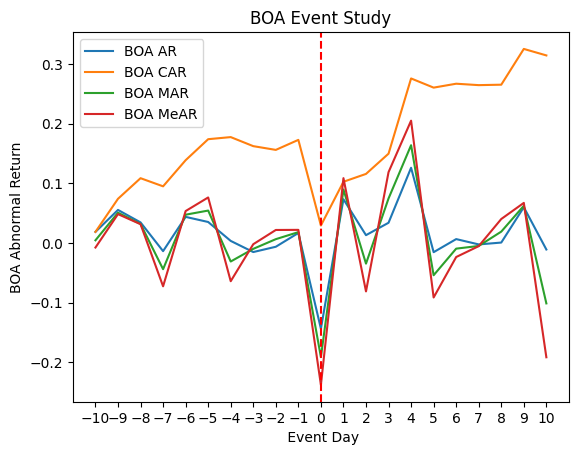

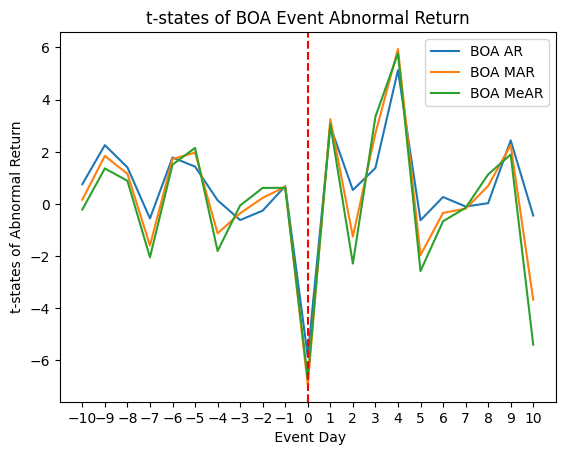

,t_stat AR,t_stat MAR,t_stat MeAR,Abnormal Return,Market Adj.,Mean Adj.,Cum. AR
-10,0.759095,0.164871,-0.213563,0.018667,0.004549,-0.007587,0.018667
-9,2.256108,1.842760,1.363046,0.055479,0.050840,0.048422,0.074146
-8,1.404372,1.156560,0.888229,0.034534,0.031909,0.031554,0.108680
-7,-0.554860,-1.591778,-2.043946,-0.013644,-0.043916,-0.072612,0.095036
-6,1.781300,1.720852,1.508252,0.043803,0.047477,0.053581,0.138839
-5,1.432973,1.971898,2.150274,0.035238,0.054403,0.076389,0.174077
-4,0.142605,-1.124114,-1.803361,0.003507,-0.031013,-0.064065,0.177583
-3,-0.616865,-0.356219,-0.056695,-0.015169,-0.009828,-0.002014,0.162414
-2,-0.255491,0.233925,0.615025,-0.006283,0.006454,0.021849,0.156132
-1,0.683669,0.661146,0.620488,0.016812,0.018240,0.022043,0.172944


In [94]:
# def event_study(df, Target_locN, MktRet_locN, event_iloc, 
#                 N_pre, N_window=21, str_name='Target Asset'):
boa =\
    pd.read_csv('BOA_Event_Study.csv')
# Event date on 15 Sep 2008
boa_event_iloc =\
    boa\
    .loc[boa['Date']=='15/9/2008']\
    .index[0]

# Selecting only rows from -250 days to -11 (inclusive)
# trading days from event date
# Event period is -10, 0, +10, total 21 days
boa_study =\
    event_study(boa, -2, -1, boa_event_iloc, 
                250, 21, 'BOA')
boa_study

                            OLS Regression Results                            
Dep. Variable:                CSI_Ret   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     190.3
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           3.30e-32
Time:                        20:34:01   Log-Likelihood:                 586.23
No. Observations:                 240   AIC:                            -1168.
Df Residuals:                     238   BIC:                            -1162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -1.596      0.1

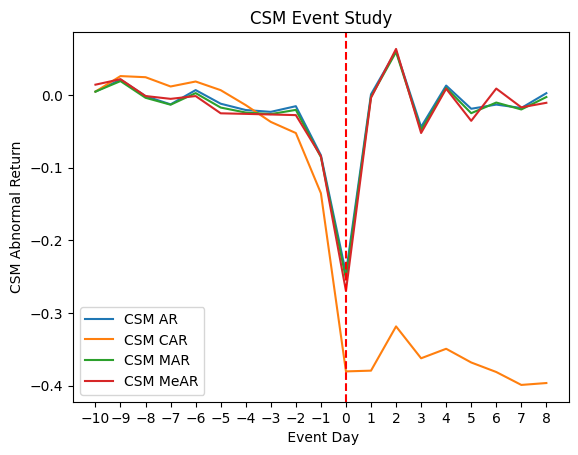

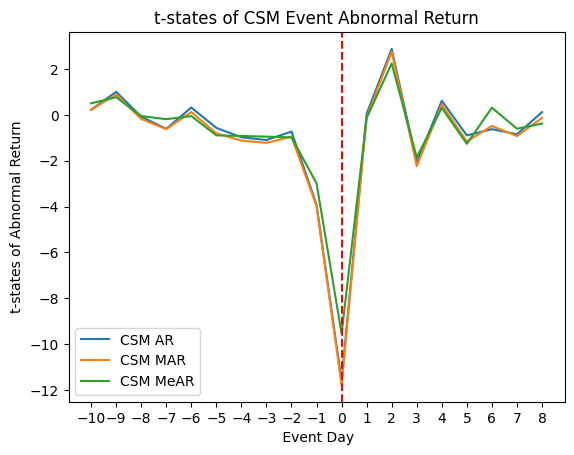

,t_stat AR,t_stat MAR,t_stat MeAR,Abnormal Return,Market Adj.,Mean Adj.,Cum. AR
-10,0.225816,0.219458,0.506650,0.004770,0.004713,0.014297,0.004770
-9,1.010730,0.894554,0.774380,0.021350,0.019213,0.021852,0.026120
-8,-0.073090,-0.174486,-0.047122,-0.001544,-0.003747,-0.001330,0.024576
-7,-0.604637,-0.618430,-0.184735,-0.012772,-0.013282,-0.005213,0.011804
-6,0.324289,0.125759,-0.048706,0.006850,0.002701,-0.001374,0.018654
-5,-0.564014,-0.801223,-0.889696,-0.011914,-0.017208,-0.025106,0.006740
-4,-0.974647,-1.120397,-0.917490,-0.020588,-0.024063,-0.025890,-0.013847
-3,-1.093789,-1.219472,-0.946909,-0.023104,-0.026191,-0.026721,-0.036951
-2,-0.724669,-0.949580,-0.978100,-0.015307,-0.020394,-0.027601,-0.052259
-1,-3.921023,-3.975020,-2.980481,-0.082824,-0.085372,-0.084105,-0.135083


In [95]:
# def event_study(df, Target_locN, MktRet_locN, event_iloc, 
#                 N_pre, N_window=21, str_name='Target Asset'):
csm =\
    pd.read_csv('CSM_Event_Study.csv')
# Event date on 2 Sep 2002
csm_event_iloc =\
    csm\
    .loc[csm['Date']=='2/9/2002']\
    .index[0]

# Selecting only rows from -250 days to -11 (inclusive)
# trading days from event date
# Event period is -10, 0, +10, total 21 days
csm_study =\
    event_study(csm, -2, -1, csm_event_iloc, 
                250, 21, 'CSM')
csm_study

##### <a id = "p23"> </a> 2.3 Homework 1 [back to table of contents](#top)

Narrative:
* On 13 December 2022, 7:00am ET (U.S. Easter Time, NY Time), Moderna and Merck announced that mRNA4157/V940, a cancer vaccine, demonstrated a statistically significant and clinically meaningful reduction in the risk of disease recurrence or death compared to KEYTRUDA monotherapy in stage III/IV melanoma patients.
* The regular trading hours for the U.S. stock market, which includes the Nasdaq Stock Market (Nasdaq) and the New York Stock Exchange (NYSE) are 9:30 a.m. to 4 p.m. Below, we see the recent traded stock price of Moderna Inc (MRNA, NASQAQ).


Requirements:
* Perform an event study on this corporate announcement on 13 December 2022. Use the testing framework: 240 prior trading days for estimation, and the 21 days for event window. Download the necessary data Moderna.csv from ELEARN. 
* SPX_Ret is the continuously compounded daily return rate on the S&P 500 Index. Use this to represent the U.S. market return. MRNA_Ret is the continuously compounded return rate of Moderna stock. 
* (Ignore dividends in the computations.) Then answer the following 5 Questions.

In [96]:
def Moderna_event_study(df, Target_locN, MktRet_locN, event_iloc, 
                N_pre, N_window=21, str_name='Target Asset'):

    estimation =\
        df.iloc[event_iloc-N_pre:
                event_iloc-N_window//2]
#     print(event_iloc-N_pre, event_iloc-N_window//2)    
    X2 =\
        estimation.iloc[:, MktRet_locN] 
    Y2 =\
        estimation.iloc[:, Target_locN]
    Z2 = sm.add_constant(X2)
    MM_model = sm.OLS(Y2, Z2).fit()
    MM_predictions = MM_model.predict(Z2) 
    MM_results = MM_model.summary()
    
    event =\
        df.iloc[event_iloc-N_window//2:
                event_iloc+N_window//2+1]
#     print(event_iloc-N_window//2, event_iloc+N_window//2+1)
    X3 =\
        event.iloc[:, MktRet_locN]
    Y3 =\
        event.iloc[:, Target_locN]
    C = MM_model.params
    ### C[0] gives intercept estimate; C[1] gives slope estimate
    ### Compute Abnormal Return AR 
    AR = Y3 - C[0] - C[1]*X3
    ### Compute Cumulative Abnormal Return CAR    
    CAR = AR.cumsum()    
    ### Compute Market Adjusted Return MAR     
    MAR = Y3 - X3
    ### Compute Mean Adjusted Return MeAR
    MeAR=Y3-np.mean(Y2)

    time =\
        range(-(N_window//2),
              N_window-(N_window//2),
              1)  ### range(start, stop, step)
    # plotting the points 
    time =\
    time[:len(AR)]
    
    plt.plot(time, AR)
    plt.plot(time, CAR)    
    plt.plot(time, MAR)  
    plt.plot(time, MeAR)
    
    plt.xticks(list(time))
    # Add a vertical line at x = 0
    plt.axvline(x=0, color='red', linestyle='--', label='Event Day')

    # naming the x axis
    plt.xlabel(' Event Day')
    # naming the y axis
    plt.ylabel(str_name+' Abnormal Return')
    # giving a title to my graph
    plt.title(str_name + ' Event Study')
    plt.legend([str_name+' AR',
                str_name+' CAR',
                str_name+' MAR',
                str_name+' MeAR'])
    plt.show()    
    
    
    sigma=np.sqrt(MM_model.mse_resid)
    t_stat_AR=AR/sigma    
    sd=np.sqrt(range(1,N_window+1,1)*(sigma**2))    
    
    sd2=np.std(Y2-X2)
    t_stat_MAR=MAR/sd2
    
    sd3=np.std(Y2-np.mean(Y2))
    t_stat_MeAR=MeAR/sd3

    
    plt.plot(time, t_stat_AR) 
    plt.plot(time, t_stat_MAR)  
    plt.plot(time, t_stat_MeAR)
    plt.xticks(list(time))
    plt.axvline(x=0, color='red', linestyle='--', label='Event Day')

    # naming the x axis
    plt.xlabel(' Event Day')
    # naming the y axis
    plt.ylabel('t-states of Abnormal Return')
    # giving a title to my graph
    plt.title('t-states of ' +str_name+ ' Event Abnormal Return')
    plt.legend([str_name+' AR',
                str_name+' MAR',
                str_name+' MeAR'])
    plt.show()
    
    plt.plot(time, MAR-AR)  
    plt.plot(time, MeAR-AR)
    
    plt.xticks(list(time))
    # Add a vertical line at x = 0
    plt.axvline(x=0, color='red', linestyle='--', label='Event Day')

    # naming the x axis
    plt.xlabel(' Event Day')
    # naming the y axis
    plt.ylabel(str_name+' Abnormal Return')
    # giving a title to my graph
    plt.title(str_name + ' Event Study')
    plt.legend([str_name+' MAR-AR',
                str_name+' MeAR-AR'])
    plt.show()        
    
    t_stat =\
        pd.concat([t_stat_AR, t_stat_MAR, t_stat_MeAR, 
                   AR, MAR, MeAR, CAR], 
                  axis=1)
    t_stat.columns =\
        ['t_stat AR', 't_stat MAR', 't_stat MeAR', 
         'Abnormal Return', 'Market Adj.', 'Mean Adj.', 'Cum. AR']   
    t_stat.index = list(time)
    
    return t_stat

In [97]:
# def event_study(df, Target_locN, MktRet_locN, event_iloc, 
#                 N_pre, N_window=21, str_name='Target Asset'):
Moderna =\
    pd.read_csv('Moderna.csv')
Moderna.head(10)

,Date,SPX_index,Moderna_Price,SPX_Ret,MRNA_Ret
0,1-Sep-21,"4,524.09",389.940002,NaN,NaN
1,2-Sep-21,"4,536.95",397.660004,0.002839,0.019604
2,3-Sep-21,"4,535.43",416.700012,-0.000335,0.046769
3,7-Sep-21,"4,520.03",436.390015,-0.003401,0.046170
4,8-Sep-21,"4,514.07",422.899994,-0.001319,-0.031401
5,9-Sep-21,"4,493.28",455.920013,-0.004616,0.075182
6,10-Sep-21,"4,458.58",449.380005,-0.007753,-0.014449
7,13-Sep-21,"4,468.73",419.720001,0.002274,-0.068281
8,14-Sep-21,"4,443.05",427.709991,-0.005763,0.018858
9,15-Sep-21,"4,480.70",434.459991,0.008438,0.015658


In [98]:
# Event date on 13 December 2022
Moderna_event_iloc =\
    Moderna\
    .loc[Moderna['Date']=='13-Dec-22']\
    .index[0]
Moderna_event_iloc

323

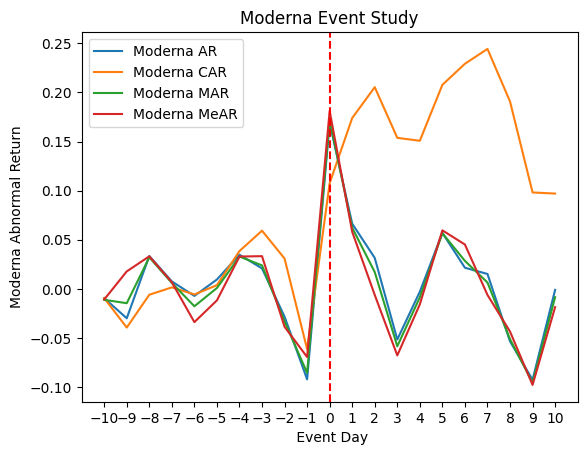

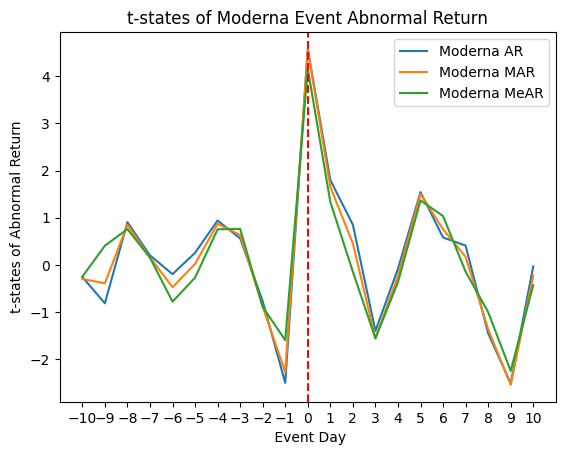

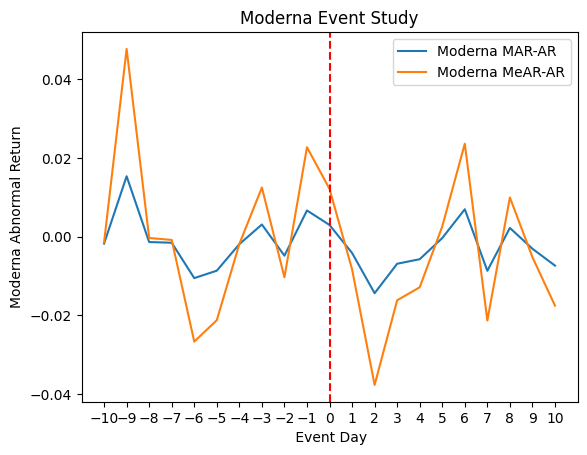

,t_stat AR,t_stat MAR,t_stat MeAR,Abnormal Return,Market Adj.,Mean Adj.,Cum. AR
-10,-0.255766,-0.297481,-0.249932,-0.009445,-0.011204,-0.010890,-0.009445
-9,-0.813102,-0.389367,0.406710,-0.030026,-0.014664,0.017721,-0.039470
-8,0.904829,0.850750,0.759199,0.033413,0.032041,0.033080,-0.006058
-7,0.203766,0.158724,0.153524,0.007525,0.005978,0.006689,0.001467
-6,-0.196014,-0.472241,-0.778827,-0.007238,-0.017786,-0.033935,-0.005771
-5,0.256632,0.021926,-0.270157,0.009477,0.000826,-0.011771,0.003705
-4,0.940917,0.872016,0.754720,0.034745,0.032842,0.032885,0.038451
-3,0.562236,0.633357,0.763196,0.020762,0.023853,0.033254,0.059213
-2,-0.768664,-0.882349,-0.888206,-0.028385,-0.033231,-0.038701,0.030828
-1,-2.497625,-2.272066,-1.594728,-0.092230,-0.085570,-0.069485,-0.061402


In [99]:
# def event_study(df, Target_locN, MktRet_locN, event_iloc, 
#                 N_pre, N_window=21, str_name='Target Asset'):

# Selecting only rows from -250 days to -11 (inclusive)
# trading days from event date
# Event period is -10, 0, +10, total 21 days
Moderna_study =\
    Moderna_event_study(Moderna, -1, -2, Moderna_event_iloc, 
                250, 21, 'Moderna')
Moderna_study

In [100]:
t_statistic =\
    Moderna_study.loc[:, 't_stat AR']

# Degrees of freedom (sample size - 1)
degrees_of_freedom = len(Moderna_study) - 1

# Calculate the two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=degrees_of_freedom))
p_value

array([8.00743699e-01, 4.25733638e-01, 3.76327197e-01, 8.40595247e-01,
       8.46576916e-01, 8.00084556e-01, 3.57974311e-01, 5.80202615e-01,
       4.51074944e-01, 2.13414728e-02, 1.83329461e-04, 8.73824321e-02,
       4.04492951e-01, 1.77248292e-01, 9.36914354e-01, 1.38536687e-01,
       5.67475909e-01, 6.86756541e-01, 1.62667115e-01, 2.08014468e-02,
       9.76055945e-01])

In [101]:
t_statistic =\
    Moderna_study.loc[0, 't_stat AR']

# Degrees of freedom (sample size - 1)
degrees_of_freedom = len(Moderna_study) - 1

# Calculate the two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=degrees_of_freedom))
p_value

0.00018332946083909896

#### Homework 1:
1. C -0.0094, 0.1690, -0.0011
2. A -0.0614, 0.1076, 0.1739
3. A (graph)
4. D 4.56, 0.000
5. C Semi-Strong form Info efficient

## <a id = "p3"> Lecture 3. </a> Time Series Modeling [back to table of contents](#top)

Documentation for an example of 
* statsmodels.tsa.statespace.sarimax.SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)

In [102]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller

##### <a id = "p31"> </a> 3.1 function definition [back to table of contents](#top)

In [103]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['10%']
    
    if (pvalue < 0.10) and (adf < critical_value):  
        ### and because statsmodel adfuller p-value is not as accurate
        print('The series is stationary, \
reject null at 10% significance level')
        return True
    else:
        print('The series is NOT stationary, \
do not reject null at 10% significance level')
        return False

In [104]:
def TS_modeling_lg(data, Target_locN, date_locN, 
                   SeasonN, str_name="Time Series Data"):
    data = data.copy()
    target_name =\
        data.columns[Target_locN]
    data["Ln_change"] =\
        np.log(data.iloc[:,Target_locN])

    ts_plot_df =\
        data.iloc[:,:-1]
    ts_plot_df[ts_plot_df.columns[date_locN]] =\
        ts_plot_df[ts_plot_df.columns[date_locN]].astype("datetime64[ns]")
    ts_plot_df =\
        ts_plot_df.set_index(ts_plot_df.columns[date_locN])
    raw = ts_plot_df[target_name]

    plt.plot(raw, marker='')
    # Labelling 
    plt.xlabel("Year")
    plt.ylabel(f"{str_name}")
    plt.title(f"{str_name} plot over time")
    # Display
    plt.show()  
    
    plot_acf(data.iloc[:,-1], 
             lags=40, 
             title="ACF on lg change");
    plot_pacf(data.iloc[:,-1], 
              method='ywm', 
              lags=40, 
              title="PACF on lg change");
    ##.shift(12) means to subtract from 12 mths earlier    
    ln_wo_seasonal =\
        data.iloc[:,-1]-\
        data.iloc[:,-1].shift(SeasonN) ##.shift(SeasonN) means to subtract from 12 mths earlier
    data[f"Ln_change_{SeasonN}"] =\
        ln_wo_seasonal  

    plot_acf(ln_wo_seasonal.dropna(), 
             lags=40, 
             title="ACF after Seasonal Diff");
    plot_pacf(ln_wo_seasonal.dropna(), 
              method='ywm', 
              lags=40, 
              title="PACF after Seasonal Diff");  

    
    print('ADF Statistic: %f' %\
          adfuller(ln_wo_seasonal.dropna())[0])
    print('p-value: %f' %\
          adfuller(ln_wo_seasonal.dropna())[1])
    stationarity =\
        check_stationarity(ln_wo_seasonal.dropna()) 

    if not stationarity:
        print('Please try other ARIMA order!')
        return
    
    ### Apply (1,0,1) x (0,1,0)_12 
    model0 =\
        sm.tsa.statespace.SARIMAX(data['Ln_change'],
                                  order=(1,0,1), 
                                  seasonal_order=(0, 1, 0, 12))  
    model0_fit=model0.fit(disp=0)
#     print(model0_fit.summary())
    
    ### Apply (1,0,1) directly to lnair12 -- avoid initial 12 obs null in fitting later
    ### Results slightly diff cos internally treating NA in first 12 obs is a bit different
    model1 =\
        sm.tsa.statespace.SARIMAX(data[f"Ln_change_{SeasonN}"], 
                                  trend='c', 
                                  order=(1,0,1))  
    model1_fit=model1.fit(disp=0)
#     print(model1_fit.summary())
    ### constant c is added        
    ### Plot residual errors
    ### See https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
    residuals1 = model1_fit.resid
    fig,ax = plt.subplots(2,1,constrained_layout = True)
    residuals1.plot(title="Residuals", ax=ax[0])
    residuals1.plot(kind='kde',title='Density',ax=ax[1])
    plt.show()
    ##resi=pd.DataFrame(model1_fit.resid)  ### convert back to pandas df   
    predictions1 =\
        model1.fit().predict() 
    ### Note: 'predict' is just fitting here
#     print(predictions1)
    err1=\
        abs(predictions1-ln_wo_seasonal.dropna())
#     print(err1.dropna())
    err1na=err1.dropna()
    print("mean abs error for m1 =", 
          np.sum(err1na)/err1na.size)
    predict1=predictions1 + data['Ln_change'].shift(SeasonN)
    ## convert ln back to raw levels
    Epredict1=np.exp(predict1)
    plt.figure(figsize=(16,4))
    plt.plot(data[target_name], label="Actual")
    plt.plot(Epredict1, label="Predicted")
    plt.title(f'{str_name} modeled (1,0,1)_{SeasonN}',
              fontsize=20)
    plt.ylabel(str_name, fontsize=16)
    plt.legend()
    
    
    ### Apply (1,0,6) directly to lnair12 -- avoid initial 12 obs null in fitting later
    ### Results slightly diff cos of 144 vs 132, treating of starting value
    model2 =\
        sm.tsa.statespace.SARIMAX(data.iloc[:,-1], 
                                  trend='c', 
                                  order=(1,0,6))  
    model2_fit=\
        model2.fit(disp=0,maxiter=250)  
    ## incr maxiter avoids 'nonconverg of ML'
#     print(model2_fit.summary())
    ### Plot residual errors
    residuals2 = model2_fit.resid
    fig,ax = plt.subplots(2,1,constrained_layout = True)
    residuals2.plot(title="Residuals", ax=ax[0])
    residuals2.plot(kind='kde',title='Density',ax=ax[1])
    plt.show()    
    ### Note: 'predict' is just fitting here
    predictions2 = model2.fit().predict()  
    ### print without truncation
    pd.set_option('display.max_rows', None)  
#     print(predictions2)
    err2=abs(predictions2-ln_wo_seasonal.dropna())
#     print(err2.dropna())
    err2na=err2.dropna()
    print("mean abs error for m2=", 
          np.sum(err2na)/err2na.size)    

    predict2=predictions2 + data['Ln_change'].shift(SeasonN)
    ## convert ln back to raw levels
    Epredict2=np.exp(predict2)
    plt.figure(figsize=(16,4))
    plt.plot(data[target_name], label="Actual")
    plt.plot(Epredict2, label="Predicted")
    plt.title(f'{str_name} modeled (1,0,6)_{SeasonN}',
              fontsize=20)
    plt.ylabel(str_name, fontsize=16)
    plt.legend()
    plt.show()
    
    err_df =\
        pd.concat([predictions1, err1, predictions2, err2], 
                  axis=1)
    err_df.columns =\
        ['model1 pred_', 'm1 err',
         'model2 pred_', 'm2 err']
    return pd.concat([data, err_df], axis=1), model0_fit, model1_fit, model2_fit

##### <a id = "p32"> </a> 3.2 Results [back to table of contents](#top)

In [105]:
# Dataset 'Airline-passengers.csv'
airline = pd.read_csv('Airline-passengers.csv') 
airline.isnull().sum()
# airline= airline.dropna()

Month         0
Passengers    0
dtype: int64

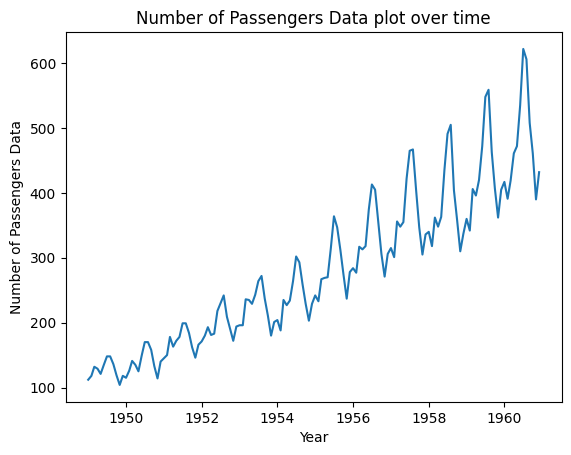

ADF Statistic: -2.709577
p-value: 0.072396
The series is stationary, reject null at 10% significance level


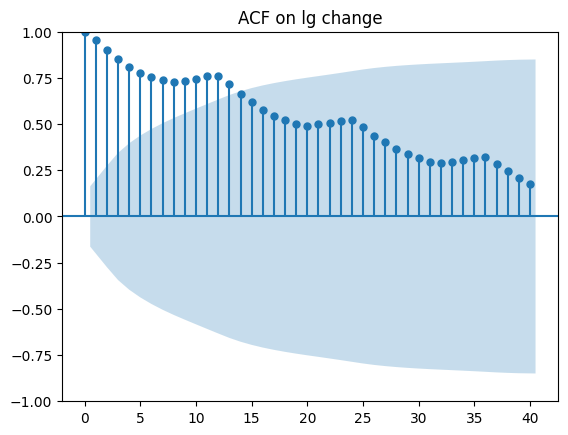

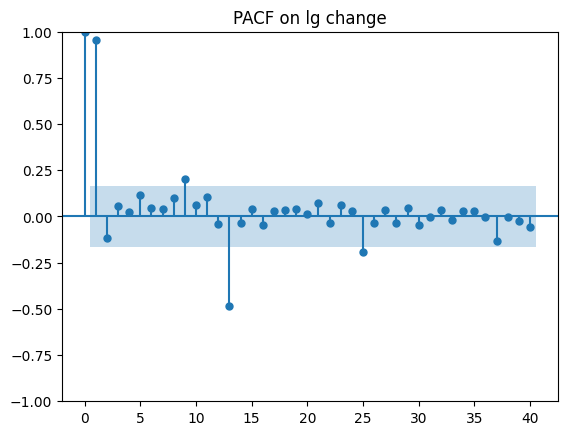

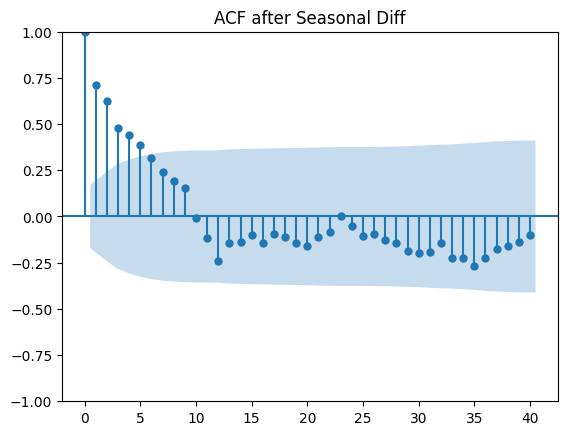

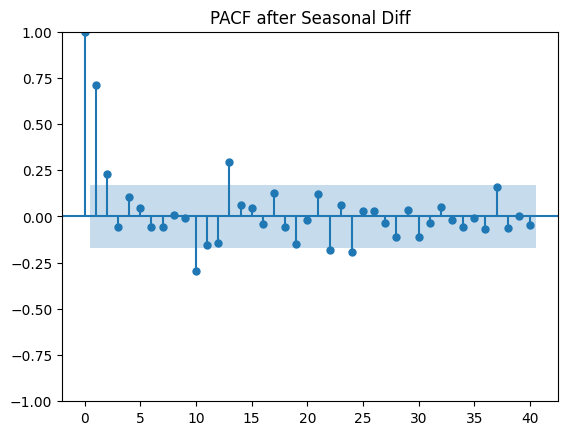

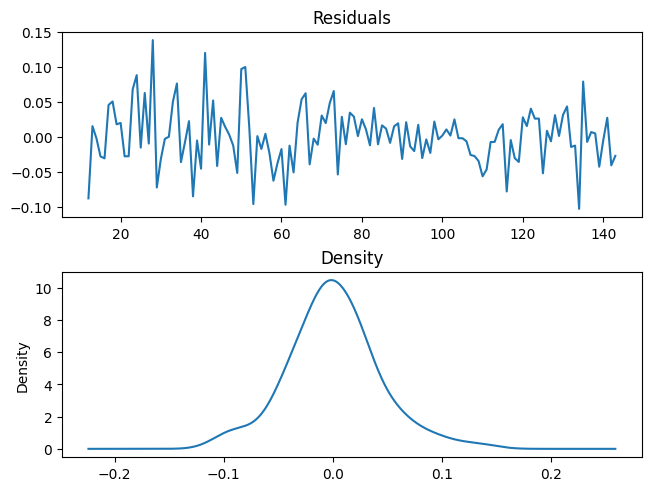

mean abs error for m1 = 0.03125089122758878


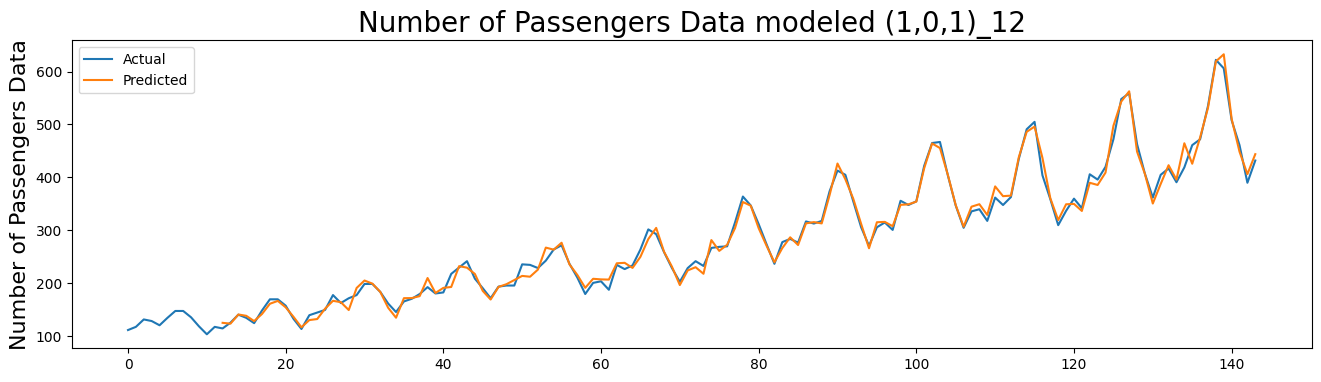

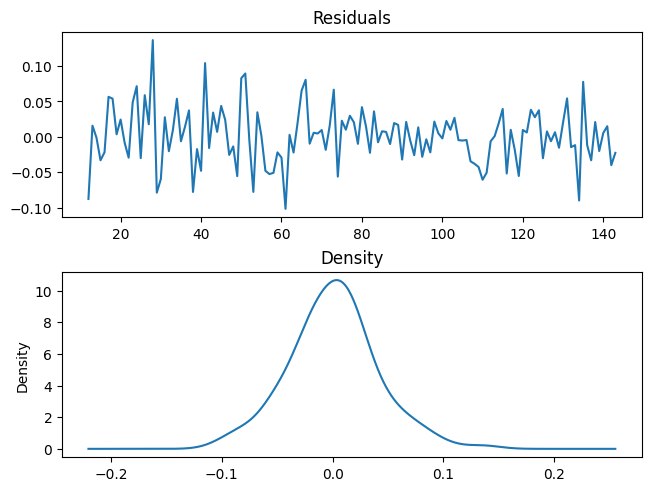

mean abs error for m2= 0.030450390704892156


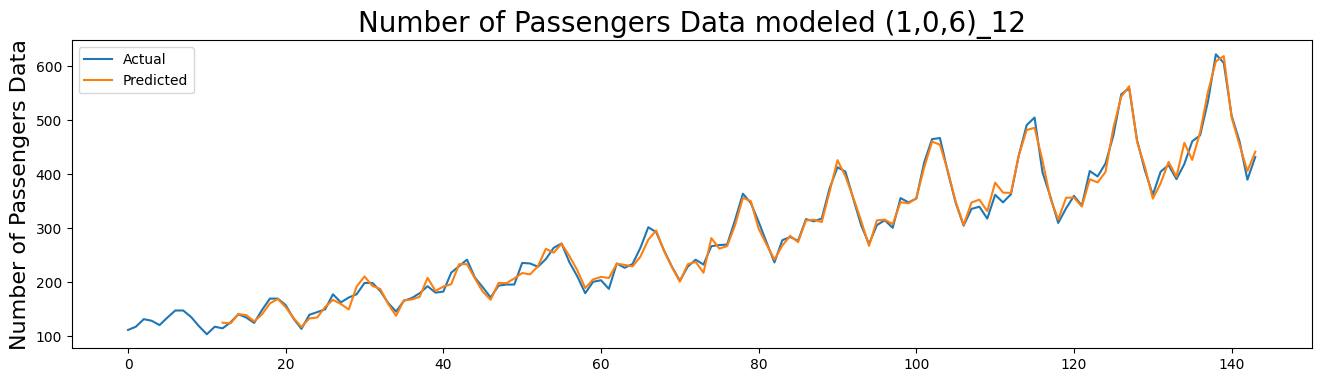

,Month,Passengers,Ln_change,Ln_change_12,model1 pred_,m1 err,model2 pred_,m2 err
137,1960-06,535,6.282267,0.125288,0.118524,0.006764,0.157979,0.032692
138,1960-07,622,6.432940,0.126665,0.121837,0.004827,0.105434,0.021231
139,1960-08,606,6.406880,0.080731,0.123569,0.042838,0.101368,0.020638
140,1960-09,508,6.230481,0.092754,0.097786,0.005032,0.086953,0.005802
141,1960-10,461,6.133398,0.124585,0.097320,0.027264,0.110291,0.014294
142,1960-11,390,5.966147,0.074503,0.115396,0.040893,0.114596,0.040094
143,1960-12,432,6.068426,0.064539,0.091895,0.027357,0.086992,0.022454


In [106]:
# def TS_modeling_lg(data, Target_locN, date_locN, 
#                    SeasonN, str_name="Time Series Data"):
airline_model, m0, m1, m2 =\
    TS_modeling_lg(airline, -1, 0, 12,
                   "Number of Passengers Data")
airline_model.tail(7)

In [107]:
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Ln_change   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                 228.678
Date:                             Mon, 19 Feb 2024   AIC                           -451.355
Time:                                     20:34:04   BIC                           -442.707
Sample:                                          0   HQIC                          -447.841
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9768      0.017     56.228      0.000       0.943       1.011
ma.L1         -0.3738      0.075     -4.952      0.000      -0.522      -0.226
sigma2         0.0018      0.000      9.271      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.70
Prob(Q):                              1.00   Prob(JB):                         0.16
Heteroskedasticity (H):               0.40   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# m1.summary()

In [109]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Ln_change_12   No. Observations:                  144
Model:               SARIMAX(1, 0, 6)   Log Likelihood                 238.866
Date:                Mon, 19 Feb 2024   AIC                           -459.732
Time:                        20:34:04   BIC                           -433.004
Sample:                             0   HQIC                          -448.871
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0254      0.011      2.220      0.026       0.003       0.048
ar.L1          0.7772      0.085      9.190      0.000       0.611       0.943
ma.L1         -0.2518      0.105     -2.405      0.016      -0.457      -0.047
ma.L2          0.1346      0.096      1.406      0.160      -0.053       0.322
ma.L3         -0.1736      0.107     -1.621      0.105      -0.383       0.036
ma.L4          0.0431      0.094      0.460      0.645      -0.140       0.227
ma.L5          0.1692      0.097      1.753      0.080      -0.020       0.358
ma.L6          0.3003      0.111      2.704      0.007       0.083       0.518
sigma2         0.0015      0.000      7.751      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.92
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.59   Skew:                             0.29
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### <a id = "p33"> </a> 3.3 Homework 2 [back to table of contents](#top)

In [110]:
# def TS_modeling_lg(data, Target_locN, date_locN, 
#                    SeasonN, str_name="Time Series Data"):
IEA =\
    pd.read_csv('IEA_Electricity.csv')
IEA.isnull().sum()
# IEA= IEA.dropna()

Country    0
Time       0
Balance    0
Product    0
Value      0
Unit       0
dtype: int64

In [111]:
IEA.Country.unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia',
       'Costa Rica', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg',
       'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
       'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Republic of Turkiye', 'United Kingdom',
       'United States', 'OECD Americas', 'OECD Asia Oceania',
       'OECD Europe', 'OECD Total', 'IEA Total', 'Argentina', 'Brazil',
       'Bulgaria', "People's Republic of China", 'Croatia', 'Cyprus',
       'India', 'Malta', 'North Macedonia', 'Romania', 'Serbia'],
      dtype=object)

In [112]:
IEA_target =\
    IEA.loc[IEA['Country']=='Australia']

IEA_target =\
    IEA_target.loc[IEA_target['Balance']=='Final Consumption (Calculated)']
IEA_target.head(7)

,Country,Time,Balance,Product,Value,Unit
12,Australia,Sep-22,Final Consumption (Calculated),Electricity,20161.9299,GWh
826,Australia,Aug-22,Final Consumption (Calculated),Electricity,21827.4765,GWh
1639,Australia,Jul-22,Final Consumption (Calculated),Electricity,22579.3576,GWh
2453,Australia,Jun-22,Final Consumption (Calculated),Electricity,21627.0300,GWh
3267,Australia,May-22,Final Consumption (Calculated),Electricity,20810.8818,GWh
4081,Australia,Apr-22,Final Consumption (Calculated),Electricity,19178.6644,GWh
4895,Australia,Mar-22,Final Consumption (Calculated),Electricity,21200.4373,GWh


In [113]:
IEA_target.shape

(153, 6)

In [114]:
IEA_target=IEA_target.iloc[::-1]
IEA_target=\
    IEA_target.set_index('Time')
IEA_target.index =\
    pd.to_datetime(IEA_target.index,
                   format='%b-%y')
IEA_target

,Country,Balance,Product,Value,Unit
Time,,,,,
2010-01-01,Australia,Final Consumption (Calculated),Electricity,19317.9310,GWh
2010-02-01,Australia,Final Consumption (Calculated),Electricity,17819.7690,GWh
2010-03-01,Australia,Final Consumption (Calculated),Electricity,18092.7870,GWh
2010-04-01,Australia,Final Consumption (Calculated),Electricity,16816.0050,GWh
2010-05-01,Australia,Final Consumption (Calculated),Electricity,18417.9490,GWh
2010-06-01,Australia,Final Consumption (Calculated),Electricity,18750.1540,GWh
2010-07-01,Australia,Final Consumption (Calculated),Electricity,19632.5020,GWh
2010-08-01,Australia,Final Consumption (Calculated),Electricity,19633.3510,GWh
2010-09-01,Australia,Final Consumption (Calculated),Electricity,18422.1380,GWh


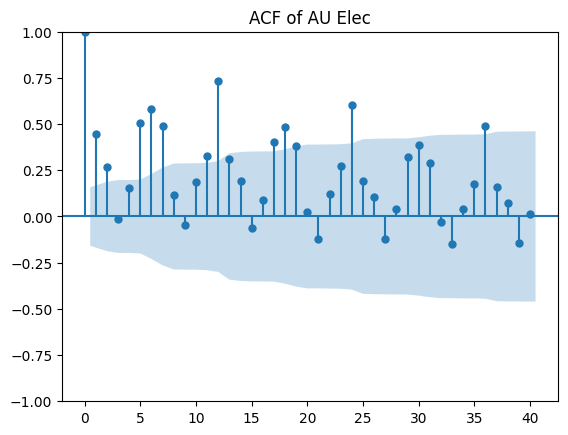

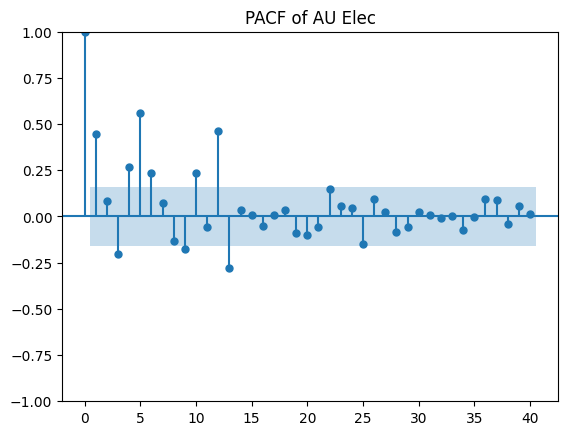

In [115]:
plot_acf(IEA_target.iloc[:,-2], 
             lags=40, 
             title="ACF of AU Elec");
plot_pacf(IEA_target.iloc[:,-2], 
              method='ywm', 
              lags=40, 
              title="PACF of AU Elec"); 

In [116]:
### Apply (1,0,1) x (0,1,0)_12 
model0 =\
        sm.tsa.statespace.SARIMAX(IEA_target.iloc[:,-2],
                                  trend='c',
                                  order=(1,0,1),
                                  seasonal_order=(0, 1, 0, 12))  
model0_fit=model0.fit(disp=0)
model0_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  153
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1116.956
Date:                             Mon, 19 Feb 2024   AIC                           2241.913
Time:                                     20:34:04   BIC                           2253.708
Sample:                                 01-01-2010   HQIC                          2246.706
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    113.9907     62.407      1.827      0.068      -8.325     236.306
ar.L1          0.4215      0.226      1.865      0.062      -0.021       0.864
ma.L1         -0.1181      0.256     -0.461      0.645      -0.620       0.384
sigma2       4.53e+05   5.03e+04      9.012      0.000    3.54e+05    5.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.89   Prob(JB):                         0.28
Heteroskedasticity (H):               0.38   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
### Apply (1,0,1) on data.diff(12)
model1 =\
        sm.tsa.statespace.SARIMAX(IEA_target.iloc[:,-2].diff(12).dropna(),
                                  trend='c',
                                  order=(1,0,1)
                                  )  
model1_fit=model1.fit(disp=0)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  141
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1122.882
Date:                Mon, 19 Feb 2024   AIC                           2253.764
Time:                        20:34:04   BIC                           2265.559
Sample:                    01-01-2011   HQIC                          2258.557
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    113.9905     56.836      2.006      0.045       2.594     225.387
ar.L1          0.5685      0.180      3.152      0.002       0.215       0.922
ma.L1         -0.2361      0.215     -1.099      0.272      -0.657       0.185
sigma2       4.53e+05   4.15e+04     10.925      0.000    3.72e+05    5.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 7.62
Prob(Q):                              0.79   Prob(JB):                         0.02
Heteroskedasticity (H):               0.31   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
# from statsmodels.stats.stattools import jarque_bera
residuals1 = model1_fit.resid
jb_test_statistic, jb_p_value, _, _ = jarque_bera(residuals1)

print("Jarque-Bera Test Statistic:", jb_test_statistic)
print("P-Value:", jb_p_value)

Jarque-Bera Test Statistic: 10.802396601139993
P-Value: 0.004511171962533896


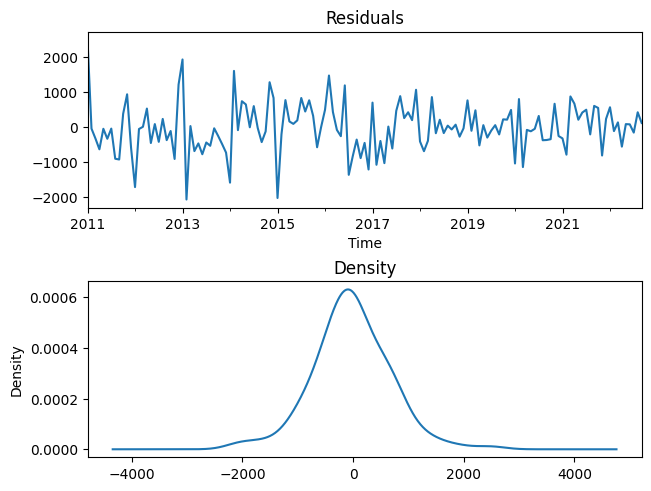

mean abs error for m1 = 19243.752695681083


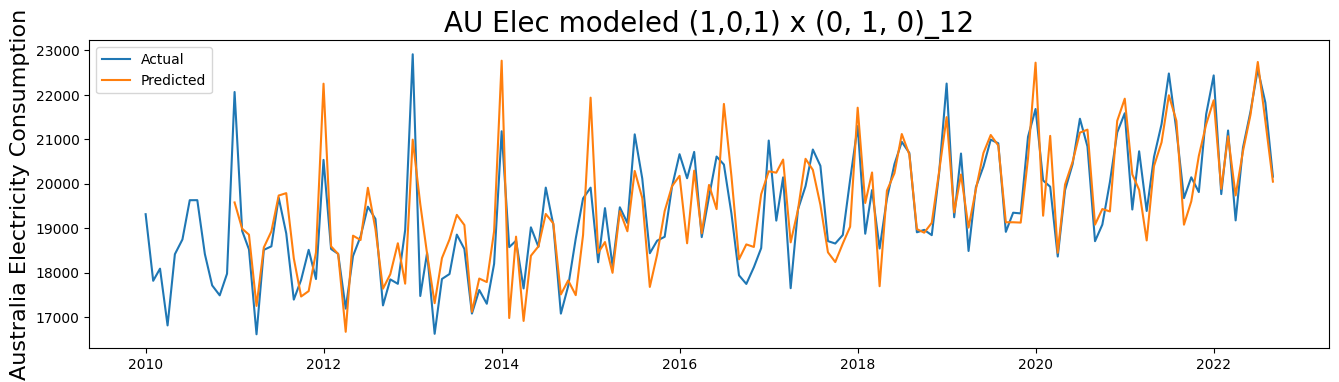

In [119]:
residuals1 = model1_fit.resid
fig,ax = plt.subplots(2,1,constrained_layout = True)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde',title='Density',ax=ax[1])
plt.show()
    ##resi=pd.DataFrame(model1_fit.resid)  ### convert back to pandas df   
predictions1 =\
        model1.fit().predict() 
    ### Note: 'predict' is just fitting here
#     print(predictions1)
err1=\
        abs(predictions1-IEA_target.iloc[:,-2].dropna())
#     print(err1.dropna())
err1na=err1.dropna()
print("mean abs error for m1 =", 
          np.sum(err1na)/err1na.size)
predict1=predictions1 + IEA_target.iloc[:,-2].shift(12)

plt.figure(figsize=(16,4))
plt.plot(IEA_target.iloc[:,-2], label="Actual")
plt.plot(predict1, label="Predicted")
plt.title('AU Elec modeled (1,0,1) x (0, 1, 0)_12',
              fontsize=20)
plt.ylabel('Australia Electricity Consumption', fontsize=16)
plt.legend()

In [120]:
pct_error =\
    (predict1-IEA_target.iloc[:,-2])/IEA_target.iloc[:,-2]

pct_error.max(), pct_error.min()

(0.11828284184426156, -0.11258417903232566)

#### Homework 2:
1. C
2. D 114, 0.57, -0.24
3. C 7.62, No
4. D
5. C -11.3%, 11.8%

## <a id = "p4"> Lecture 4. </a> Multivariate Regression [back to table of contents](#top)

In [121]:
# from statsmodels.formula.api import ols
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.stats.diagnostic import het_white
# from scipy.linalg import toeplitz
STI =\
    pd.read_csv('STI_1994-2002.csv')
print(STI.shape) 
STI.isnull().sum()    

(2160, 9)


Date           0
Day            0
index level    0
contcpdret     1
d1             0
d2             0
d3             0
d4             0
d5             0
dtype: int64

##### <a id = "p41"> </a> 4.1 function definition [back to table of contents](#top)

In [122]:
def MultiVar_Reg(df, Target_locN, Dummy_locN_list, str_name_list, part_pct,
                formula_ols, hypotheses_ols, title_ols):
    if len(Dummy_locN_list) != len(str_name_list):
        print ('Different Length detected')
        return
    precision = 5
    dummy_df =\
        pd.DataFrame()
    for dummy_loc in Dummy_locN_list:
        temp_df =\
            pd\
            .DataFrame(df.loc[df.iloc[:,dummy_loc]==1]\
                       .iloc[:,Target_locN])\
            .reset_index(drop=True)
        dummy_df =\
            pd.concat([dummy_df, temp_df],
                      axis=1)
    dummy_df.columns =\
        str_name_list
    dummy_df =\
        dummy_df.dropna()
    dummy_df =\
        dummy_df.reset_index(drop=True)

    metrics =\
        pd.DataFrame(columns = ['Mean', 'Std', 't_value'])
    
    for col in dummy_df.columns:
        mean=dummy_df[col].mean()
        std=np.std(dummy_df[col])
        metrics.loc[col,'Mean'] =\
            round(mean,precision)
        metrics.loc[col,'Std'] =\
            round(std,precision)    
        metrics.loc[col,'t_value'] =\
            round(np.sqrt(len(dummy_df))*\
                  mean/std,
                  precision) 
    seg_dummy_df =\
        dummy_df.iloc[:int(len(dummy_df)*part_pct),:]  
    
    ### Choose first half of data        
    seg_df =\
        df\
        .iloc[:int(len(df)*part_pct),:]\
        .dropna()\
        .reset_index(drop=True)
    
    target = str(df.columns[Target_locN])
    dummies = list(df.columns[Dummy_locN_list])
    
    formula = formula_ols
    
    ols_results = ols(formula, seg_df).fit()
    for dummy_name, p in ols_results.pvalues.items(): 
### There appears to be a negative Monday effect significantly diff from zero at 1%        
        if p < 0.01:
            print(f"For half data with 1% significance, dummy is {dummy_name}, with p-value of {p}")

    hypotheses = hypotheses_ols
    t_test = ols_results.t_test(hypotheses)
    print(f"For half data t-value for hypotheses is {t_test.tvalue[0]}")
    print(f"For half data p-value for hypotheses is {t_test.pvalue[0]}")
    
### Above are t-test of 
### c0: d1-d5 if this is statistically different from zero; 
### c1: d2-d5 if this is statistically different from zero; and so on.
### Monday eff not so neg strong here (statistically same as Fri) 
### -- shows diff stat test can produce slightly diff result due to
###  their power (here do not reject H_0 even if false -- Type II error)
    sigma=np.std(ols_results.resid)
###  std error of fitted regression residual error. 
### But note Numpy np.std gives biased estimator, i.e. divide by N
    print(f"OLS std err for residual is: {sigma}") 
    v1=\
        (ols_results.mse_resid-\
         (np.mean(ols_results.resid))**2)*\
            (len(seg_df)-len(dummies))/len(seg_df)
    print(np.sqrt(v1))
    ### note .mse_resid gives unbiased estimator, i.e. SSE/(n-k). 
    ### so above v1 gives unbiased est. Change to biased by x (N-k)/N

    bigX = seg_df.iloc[:, Dummy_locN_list].to_numpy()    
    bigXT = bigX.T
    XX = (bigXT).dot (bigX)
    
    
    # Define the dimension
    d = len(dummies) - 1

    # Create Matrix R using a loop
    R = np.zeros((d, d + 1))
    for i in range(d):
        R[i, i] = 1
        R[i, -1] = -1

    # Create Matrix r using a loop
    r = np.zeros((d, 1))

    B=ols_results.params
    b=B.to_numpy() ### first, convert to numpy array
    ### to convert from (5,) or 1-dim to (5,1) or 2-dim for np matrix multiplication
    beta = b.reshape(len(Dummy_locN_list), 1)
    M = R.dot(np.linalg.inv(XX)).dot(R.T)
    F=(((R.dot (beta)-r).T)\
       .dot(np.linalg.inv(M))\
       .dot(R.dot (beta)-r)/d)/\
            ((len(seg_df)/(len(seg_df)-len(dummies)))*\
                (sigma)**2)

    f=F
    dfn=len(dummies)-1 # 4
    dfd=len(seg_df)-len(dummies) # 1079 - 5
    p = 1-stats.f.cdf(f, dfn, dfd)
    print(f"F-states is {F}, with degree of freedom d={dfn} and N-K={dfd}")
    print(f"F-states p is {p}")
### result p > 0.1
### Hence do not reject H_0: 
###   'd1=d5, d2=d5, d3=d5, d4=d5' at 10% significance level    

    plt.plot(ols_results.resid,linestyle="-",linewidth=1)
#     plt.title('Residuals from 18 July 1994 to 28 August 1998')
    plt.title(f'Residuals from OLS{title_ols}')
#     plt.title(f'Residuals from OLS for period 18 July 1994 to 28 August 1998')
    plt.show()

### Test for Heteroskedasticity    
    One=np.ones([len(seg_df),1])
    One=pd.DataFrame(One)    
    Dx=pd.DataFrame(seg_df.iloc[:, Dummy_locN_list])  
    Dx1=pd.concat([One,seg_df.iloc[:, Dummy_locN_list[1:]]],axis=1)  
    ### leaves out d1 to avoid dummy var trap
    
    bp_test = het_breuschpagan(ols_results.resid,Dx)
    print ('LM-test chi-sq:', bp_test[0], 'LM-test p_value:', bp_test[1])
    print(stats.chi2.ppf(1-bp_test[1], df=dfn)) # suppose to be bp_test[0]
    
    bp_test1 = het_breuschpagan(ols_results.resid,Dx1)
    print ('LM-test chi-sq:', bp_test1[0], 'LM-test p_value:', bp_test1[1]) 
    print(stats.chi2.ppf(1-bp_test1[1], df=dfn)) # suppose to be bp_test1[0]    
    
    ### White's Heteroskedasticity Test

    wh_test = het_white(ols_results.resid,Dx)
    print ('LM-test chi-sq:', wh_test[0], 'LM-test p_value:', wh_test[1])
    ### Note also 4 d.f. since dumy * other dummy = 0, and dummy^2 = same dummy of one, 
    ### hence no new regressors    
### Hence cannot reject null of no heteroskedasticity
    
    resid_fit = sm.OLS(
        np.asarray(ols_results.resid)[1:],
        sm.add_constant(np.asarray(ols_results.resid)[:-1])
    ).fit()
    print(f"OLS err collinearity t-value: {resid_fit.tvalues[1]}")
    print(f"OLS err collinearity p-value: {resid_fit.pvalues[1]}")
    rho = resid_fit.params[1]
    print(f"OLS err collinearity coef: {rho}")    
### High t-value of resid on its lag indicates 
### e(t) = const + 0.1685 e(t-1) + error


### GLS below
    trix = toeplitz(range(len(ols_results.resid))) 
    ### trix is sq matrix with zero in diag, 1 in first off diag, 2 in 2nd off diag, etc.
    sigma = rho ** trix 
    ### this is cov matrix of residuals except the factor of sigma_u^2 is left out
    gls_model = sm.GLS(seg_df[df.columns[Target_locN]],
                       Dx, 
                       sigma=sigma)
    gls_results = gls_model.fit()
    print(f"GLS std err est {np.sqrt(gls_results.mse_resid)}")
### taking this as std err est assumes E(resid error) = 0

### Here we perform a HAC (heteroskedasticity-autocorrelation consistent cov estimator)
    model = sm.OLS(seg_df[df.columns[Target_locN]], Dx)
    ols_hc = model.fit(cov_type="HC3")

### Note above results are close to the previous case adjusting for GLS. 
###   But DW stats still indicates pos autocorr
### HC3 -- MacKinnon and White’s (1985) heteroskedasticity robust standard errors.
###   Notes. Defined as (X.T X)^(-1)X.T diag(e_i^(2)/(1-h_ii)^(2)) X(X.T X)^(-1) 
###   where h_ii = x_i(X.T X)^(-1)x_i.T.

### Now test data for next period
#     print(int(len(df)*part_pct))
    rest_df =\
        df\
        .iloc[int(len(df)*part_pct):,:]\
        .dropna()\
        .reset_index(drop=True)
    
    ols_results2 = ols(formula, rest_df).fit()
    plt.plot(ols_results2.resid,linestyle="-",linewidth=1)
#     plt.title('Residuals from 31 August 1998 to 18 October 2002')
    plt.title(f'Residuals from OLS{title_ols}')    
    plt.show()
    
    
    
    return dummy_df, metrics, ols_results, gls_results, ols_hc, ols_results2

For half data with 1% significance, dummy is d1, with p-value of 0.00932580820711746
For half data t-value for hypotheses is -1.5517724782274906
For half data p-value for hypotheses is 0.12101128173844301
OLS std err for residual is: 0.01374910349362983
0.013749103493629835
F-states is [[1.93458638]], with degree of freedom d=4 and N-K=1074
F-states p is [[0.10248109]]


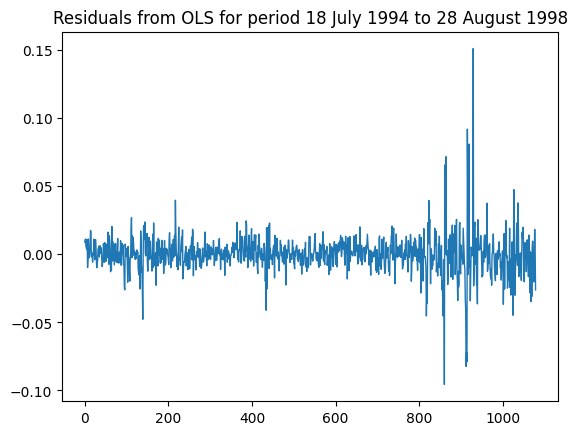

LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
6.767333462342434
LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
6.767333462342434
LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
OLS err collinearity t-value: 5.599107600370426
OLS err collinearity p-value: 2.7340423326673825e-08
OLS err collinearity coef: 0.16850705336533994
GLS std err est 0.013781666617589628


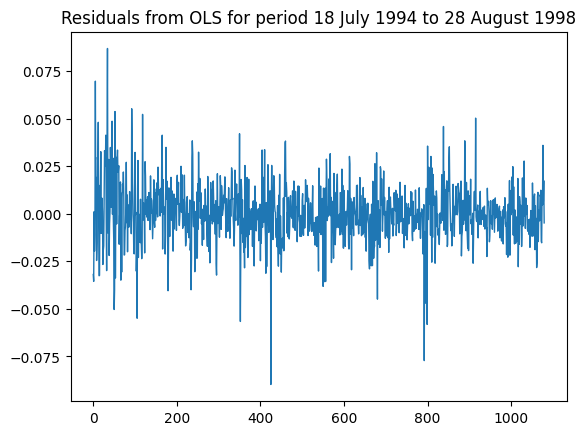

In [123]:
from statsmodels.formula.api import ols
new_col_name =\
    ['MonRet', 'TueRet', 'WedRet', 'ThuRet', 'FriRet']
formula_str = 'contcpdret ~ d1 + d2 + d3 + d4 + d5 - 1'
hypotheses_str = 'd1=d5, d2=d5, d3=d5, d4=d5'
title_str = ' for period 18 July 1994 to 28 August 1998'
sorted_df, sorted_metrics, ols, gls, ols_hc, ols2=\
    MultiVar_Reg(STI, 3, list(range(4, 9)), new_col_name, 0.5, 
                 formula_str, hypotheses_str, title_str)

In [124]:
def MultiVar_Reg(df, Target_locN, Dummy_locN_list, str_name_list, part_pct):
    if len(Dummy_locN_list) != len(str_name_list):
        print ('Different Length detected')
        return
    precision = 5
    dummy_df =\
        pd.DataFrame()
    for dummy_loc in Dummy_locN_list:
        temp_df =\
            pd\
            .DataFrame(df.loc[df.iloc[:,dummy_loc]==1]\
                       .iloc[:,Target_locN])\
            .reset_index(drop=True)
        dummy_df =\
            pd.concat([dummy_df, temp_df],
                      axis=1)
    dummy_df.columns =\
        str_name_list
    dummy_df =\
        dummy_df.dropna()
    dummy_df =\
        dummy_df.reset_index(drop=True)

    metrics =\
        pd.DataFrame(columns = ['Mean', 'Std', 't_value'])
    
    for col in dummy_df.columns:
        mean=dummy_df[col].mean()
        std=np.std(dummy_df[col])
        metrics.loc[col,'Mean'] =\
            round(mean,precision)
        metrics.loc[col,'Std'] =\
            round(std,precision)    
        metrics.loc[col,'t_value'] =\
            round(np.sqrt(len(dummy_df))*\
                  mean/std,
                  precision) 
    seg_dummy_df =\
        dummy_df.iloc[:int(len(dummy_df)*part_pct),:]  
    
    ### Choose first half of data        
    seg_df =\
        df\
        .iloc[:int(len(df)*part_pct),:]\
        .dropna()\
        .reset_index(drop=True)
    
    target = str(df.columns[Target_locN])
    dummies = list(df.columns[Dummy_locN_list])
    
    formula_str = target + ' ~ '
    for name in dummies:
        formula_str += str(name) + ' + '        
    formula_str =\
        formula_str[:-3] + ' - 1'
    ### Note: adding ' -1 ' removes constant or intercept
    ### Note that if we remove the  - 1, 
    ###  this statsmodel program still runs and shows regression results,
    ###  but warns of singular matrix -- other programs 
    ###  e.g. R would not return any result    
#     formula = 'contcpdret ~ d1 + d2 + d3 + d4 + d5 - 1'
    formula = formula_str
    ols_results = ols(formula, seg_df).fit()
    for dummy_name, p in ols_results.pvalues.items(): 
### There appears to be a negative Monday effect significantly diff from zero at 1%        
        if p < 0.01:
            print(dummy_name, p)

    hypotheses_choice =\
        str(dummies[-1])
    hypotheses=''
    for name in dummies[:-1]:
        hypotheses =\
            hypotheses +\
            str(name) + '=' + hypotheses_choice +', '
    
    hypotheses = hypotheses[:-2]
#     hypotheses = 'd1=d5, d2=d5, d3=d5, d4=d5'
    t_test = ols_results.t_test(hypotheses)
    print(t_test)
    
### Above are t-test of 
### c0: d1-d5 if this is statistically different from zero; 
### c1: d2-d5 if this is statistically different from zero; and so on.
### Monday eff not so neg strong here (statistically same as Fri) 
### -- shows diff stat test can produce slightly diff result due to
###  their power (here do not reject H_0 even if false -- Type II error)
    sigma=np.std(ols_results.resid)
###  std error of fitted regression residual error. 
### But note Numpy np.std gives biased estimator, i.e. divide by N
    print(sigma) 
    v1=\
        (ols_results.mse_resid-\
         (np.mean(ols_results.resid))**2)*\
            (len(seg_df)-len(dummies))/len(seg_df)
    print(np.sqrt(v1))
    ### note .mse_resid gives unbiased estimator, i.e. SSE/(n-k). 
    ### so above v1 gives unbiased est. Change to biased by x (N-k)/N

    bigX = seg_df.iloc[:, Dummy_locN_list].to_numpy()    
    bigXT = bigX.T
    XX = (bigXT).dot (bigX)
    
    
    # Define the dimension
    d = len(dummies) - 1

    # Create Matrix R using a loop
    R = np.zeros((d, d + 1))
    for i in range(d):
        R[i, i] = 1
        R[i, -1] = -1

    # Create Matrix r using a loop
    r = np.zeros((d, 1))

    B=ols_results.params
    b=B.to_numpy() ### first, convert to numpy array
    ### to convert from (5,) or 1-dim to (5,1) or 2-dim for np matrix multiplication
    beta = b.reshape(len(Dummy_locN_list), 1)
    M = R.dot(np.linalg.inv(XX)).dot(R.T)
    F=(((R.dot (beta)-r).T)\
       .dot(np.linalg.inv(M))\
       .dot(R.dot (beta)-r)/4)/\
            ((len(seg_df)/(len(seg_df)-len(dummies)))*\
                (sigma)**2)
    print(F)
    f=F
    dfn=len(dummies)-1 # 4
    dfd=len(seg_df)-len(dummies) # 1079 - 5
    p = 1-stats.f.cdf(f, dfn, dfd)
    print(p)
### result p > 0.1
### Hence do not reject H_0: 
###   'd1=d5, d2=d5, d3=d5, d4=d5' at 10% significance level    

    plt.plot(ols_results.resid,linestyle="-",linewidth=1)
#     plt.title('Residuals from 18 July 1994 to 28 August 1998')
    plt.title('Residuals from OLS for period 18 July 1994 to 28 August 1998')
    plt.show()

### Test for Heteroskedasticity    
    One=np.ones([len(seg_df),1])
    One=pd.DataFrame(One)    
    Dx=pd.DataFrame(seg_df.iloc[:, Dummy_locN_list])  
    Dx1=pd.concat([One,seg_df.iloc[:, Dummy_locN_list[1:]]],axis=1)  
    ### leaves out d1 to avoid dummy var trap
    
    bp_test = het_breuschpagan(ols_results.resid,Dx)
    print ('LM-test chi-sq:', bp_test[0], 'LM-test p_value:', bp_test[1])
    print(stats.chi2.ppf(1-bp_test[1], df=dfn)) # suppose to be bp_test[0]
    
    bp_test1 = het_breuschpagan(ols_results.resid,Dx1)
    print ('LM-test chi-sq:', bp_test1[0], 'LM-test p_value:', bp_test1[1]) 
    print(stats.chi2.ppf(1-bp_test1[1], df=dfn)) # suppose to be bp_test1[0]    
    
    ### White's Heteroskedasticity Test

    wh_test = het_white(ols_results.resid,Dx)
    print ('LM-test chi-sq:', wh_test[0], 'LM-test p_value:', wh_test[1])
    ### Note also 4 d.f. since dumy * other dummy = 0, and dummy^2 = same dummy of one, 
    ### hence no new regressors    
### Hence cannot reject null of no heteroskedasticity
    
    resid_fit = sm.OLS(
        np.asarray(ols_results.resid)[1:],
        sm.add_constant(np.asarray(ols_results.resid)[:-1])
    ).fit()
    print(resid_fit.tvalues[1])
    print(resid_fit.pvalues[1])
    rho = resid_fit.params[1]
    print(rho)    
### High t-value of resid on its lag indicates 
### e(t) = const + 0.1685 e(t-1) + error


### GLS below
    trix = toeplitz(range(len(ols_results.resid))) 
    ### trix is sq matrix with zero in diag, 1 in first off diag, 2 in 2nd off diag, etc.
    sigma = rho ** trix 
    ### this is cov matrix of residuals except the factor of sigma_u^2 is left out
    gls_model = sm.GLS(seg_df[df.columns[Target_locN]],
                       Dx, 
                       sigma=sigma)
    gls_results = gls_model.fit()
    print(np.sqrt(gls_results.mse_resid))
### taking this as std err est assumes E(resid error) = 0

### Here we perform a HAC (heteroskedasticity-autocorrelation consistent cov estimator)
    model = sm.OLS(seg_df[df.columns[Target_locN]], Dx)
    ols_hc = model.fit(cov_type="HC3")

### Note above results are close to the previous case adjusting for GLS. 
###   But DW stats still indicates pos autocorr
### HC3 -- MacKinnon and White’s (1985) heteroskedasticity robust standard errors.
###   Notes. Defined as (X.T X)^(-1)X.T diag(e_i^(2)/(1-h_ii)^(2)) X(X.T X)^(-1) 
###   where h_ii = x_i(X.T X)^(-1)x_i.T.

### Now test data for next period
#     print(int(len(df)*part_pct))
    rest_df =\
        df\
        .iloc[int(len(df)*part_pct):,:]\
        .dropna()\
        .reset_index(drop=True)
    
    ols_results2 = ols(formula, rest_df).fit()
    plt.plot(ols_results2.resid,linestyle="-",linewidth=1)
#     plt.title('Residuals from 31 August 1998 to 18 October 2002')
    plt.title('Residuals from OLS for period 31 August 1998 to 18 October 2002')    
    plt.show()
    
    
    
    return dummy_df, metrics, ols_results, gls_results, ols_hc, ols_results2

##### <a id = "p42"> </a> 4.2 Results [back to table of contents](#top)

d1 0.00932580820711746
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0021      0.001     -1.552      0.121      -0.005       0.001
c1            -0.0007      0.001     -0.534      0.594      -0.003       0.002
c2             0.0015      0.001      1.166      0.244      -0.001       0.004
c3          -4.05e-05      0.001     -0.031      0.976      -0.003       0.003
0.01374910349362983
0.013749103493629835
[[1.93458638]]
[[0.10248109]]


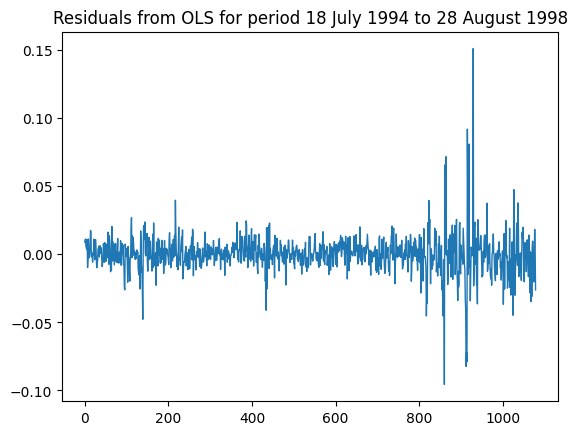

LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
6.767333462342434
LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
6.767333462342434
LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156
5.599107600370426
2.7340423326673825e-08
0.16850705336533994
0.013781666617589628


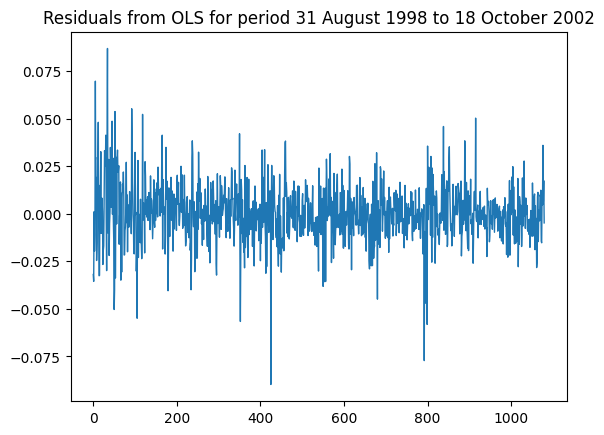

In [125]:
from statsmodels.formula.api import ols
new_col_name =\
    ['MonRet', 'TueRet', 'WedRet', 'ThuRet', 'FriRet']
sorted_df, sorted_metrics, ols, gls, ols_hc, ols2=\
    MultiVar_Reg(STI, 3, list(range(4, 9)), new_col_name, 0.5)


In [126]:
print(sorted_df.shape)
sorted_df.head(10)

(431, 5)


,MonRet,TueRet,WedRet,ThuRet,FriRet
0,0.002483,0.002368,0.012104,-0.010167,-0.003623
1,0.008716,0.000070,-0.001462,-0.000206,0.004693
2,0.015043,0.015391,-0.000665,-0.001965,-0.000619
3,-0.008207,0.000000,0.000365,0.010662,0.003021
4,-0.006450,0.000567,0.011944,0.005396,-0.004260
5,-0.012361,-0.005697,-0.004033,0.003458,0.003509
6,0.003607,-0.003066,0.006169,0.005814,0.000249
7,0.001800,0.003643,-0.002757,-0.009550,-0.006869
8,-0.007229,0.006607,0.001485,-0.006243,0.008229
9,-0.005407,0.006598,-0.004093,-0.002884,0.006889


In [127]:
sorted_metrics

,Mean,Std,t_value
MonRet,-0.00182,0.01817,-2.07633
TueRet,-0.00029,0.01284,-0.46643
WedRet,0.00059,0.01438,0.85275
ThuRet,0.00037,0.01403,0.54631
FriRet,0.00063,0.01328,0.98223


In [128]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             contcpdret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.935
Date:                Mon, 19 Feb 2024   Prob (F-statistic):              0.102
Time:                        20:34:05   Log-Likelihood:                 3094.4
No. Observations:                1079   AIC:                            -6179.
Df Residuals:                    1074   BIC:                            -6154.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0024      0.001     -2.605      0.009      -0.004      -0.001
d2            -0.0011      0.001     -1.168      0.243      -0.003       0.001
d3             0.0012      0.001      1.235      0.217      -0.001       0.003
d4            -0.0004      0.001     -0.457      0.648      -0.002       0.001
d5            -0.0004      0.001     -0.414      0.679      -0.002       0.001
==============================================================================
Omnibus:                      408.258   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21849.044
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                      24.966   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             contcpdret   R-squared:                       0.008
Model:                            GLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.064
Date:                Mon, 19 Feb 2024   Prob (F-statistic):             0.0834
Time:                        20:34:05   Log-Likelihood:                 3109.9
No. Observations:                1079   AIC:                            -6210.
Df Residuals:                    1074   BIC:                            -6185.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0025      0.001     -2.619      0.009      -0.004      -0.001
d2            -0.0011      0.001     -1.172      0.242      -0.003       0.001
d3             0.0012      0.001      1.235      0.217      -0.001       0.003
d4            -0.0004      0.001     -0.457      0.648      -0.002       0.001
d5            -0.0004      0.001     -0.412      0.680      -0.002       0.001
==============================================================================
Omnibus:                      427.101   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29712.559
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                      28.639   Cond. No.                         1.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
ols_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             contcpdret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 19 Feb 2024   Prob (F-statistic):                nan
Time:                        20:34:05   Log-Likelihood:                 3094.4
No. Observations:                1079   AIC:                            -6179.
Df Residuals:                    1074   BIC:                            -6154.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0024      0.001     -1.966      0.049      -0.005      -8e-06
d2            -0.0011      0.001     -1.228      0.219      -0.003       0.001
d3             0.0012      0.001      1.355      0.175      -0.001       0.003
d4            -0.0004      0.001     -0.476      0.634      -0.002       0.001
d5            -0.0004      0.001     -0.527      0.598      -0.002       0.001
==============================================================================
Omnibus:                      408.258   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21849.044
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                      24.966   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [131]:
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             contcpdret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.104
Date:                Mon, 19 Feb 2024   Prob (F-statistic):              0.353
Time:                        20:34:05   Log-Likelihood:                 2970.2
No. Observations:                1080   AIC:                            -5930.
Df Residuals:                    1075   BIC:                            -5906.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0012      0.001     -1.127      0.260      -0.003       0.001
d2             0.0006      0.001      0.528      0.598      -0.002       0.003
d3          6.941e-05      0.001      0.066      0.948      -0.002       0.002
d4             0.0012      0.001      1.152      0.250      -0.001       0.003
d5             0.0017      0.001      1.582      0.114      -0.000       0.004
==============================================================================
Omnibus:                       93.758   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.433
Skew:                           0.066   Prob(JB):                    1.63e-118
Kurtosis:                       6.469   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### <a id = "p43"> </a> 4.3 Homework 3 [back to table of contents](#top)

In [132]:
# def MultiVar_Reg(df, Target_locN, Dummy_locN_list, str_name_list, part_pct):
LS_day =\
    pd.read_csv('Large_Small_Day_of_Week.csv')
LS_day.head()

,Date,Days,STIR,LSR,SSR,d1,d2,d3,d4,d5
0,27/10/1997,Monday,NaN,NaN,NaN,1,0,0,0,0
1,28/10/1997,Tuesday,-0.096719,-0.088550,-0.091323,0,1,0,0,0
2,29/10/1997,Wednesday,0.066769,0.053139,0.030660,0,0,1,0,0
3,30/10/1997,Thursday,0.000000,0.000000,0.000000,0,0,0,1,0
4,31/10/1997,Friday,0.020108,0.002225,0.015986,0,0,0,0,1


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0025      0.003     -0.981      0.327      -0.007       0.002
c1            -0.0016      0.003     -0.645      0.519      -0.007       0.003
c2             0.0017      0.003      0.691      0.490      -0.003       0.007
c3            -0.0002      0.003     -0.080      0.936      -0.005       0.005
0.02033628651850557
0.020336286518505574
[[0.82743749]]
[[0.50791982]]


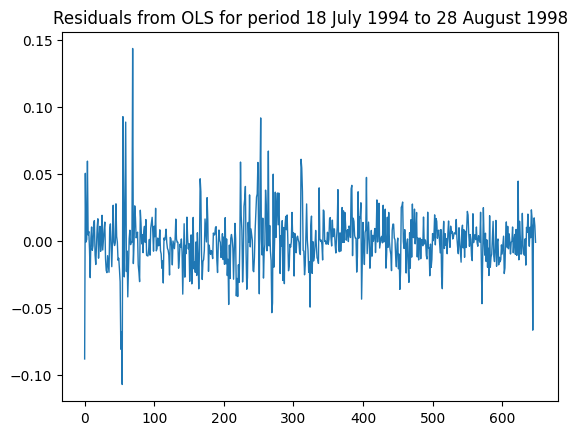

LM-test chi-sq: 9.626511545417362 LM-test p_value: 0.04721163158636218
9.62651154541736
LM-test chi-sq: 9.626511545417218 LM-test p_value: 0.04721163158636498
9.626511545417218
LM-test chi-sq: 9.626511545417362 LM-test p_value: 0.04721163158636218
3.7242985745425288
0.00021297613702465698
0.1428745939124206
0.020408897602871432


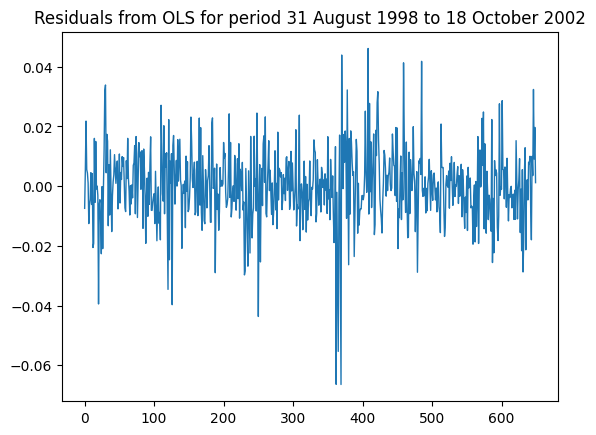

In [133]:
from statsmodels.formula.api import ols
L_col_name =\
    ['LMonRet', 'LTueRet', 'LWedRet', 'LThuRet', 'LFriRet']
L_sorted_df, L_sorted_metrics, L_ols, L_gls, L_ols_hc, L_ols2=\
    MultiVar_Reg(LS_day, 3, list(range(5, 10)), L_col_name, 0.5)

In [134]:
L_sorted_metrics

,Mean,Std,t_value
LMonRet,-0.00127,0.02148,-0.9476
LTueRet,0.00079,0.01384,0.91533
LWedRet,0.00024,0.01523,0.25654
LThuRet,0.0004,0.0157,0.41327
LFriRet,0.00061,0.01633,0.60135


d1 0.002537702652844789
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0131      0.004     -3.226      0.001      -0.021      -0.005
c1            -0.0070      0.004     -1.740      0.082      -0.015       0.001
c2             0.0003      0.004      0.069      0.945      -0.008       0.008
c3            -0.0060      0.004     -1.476      0.141      -0.014       0.002
0.032476626689308195
0.032476626689308175
[[3.74454997]]
[[0.005068]]


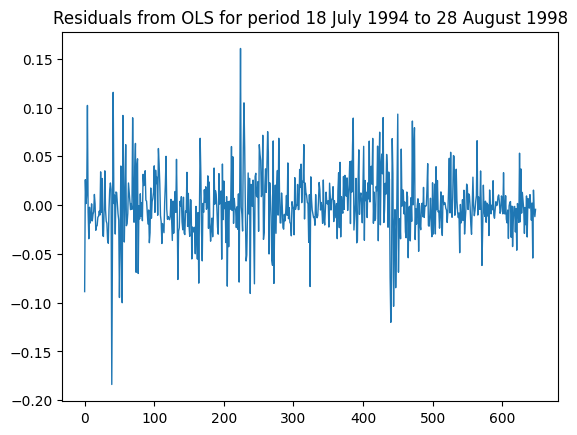

LM-test chi-sq: 21.912661037684344 LM-test p_value: 0.00020860466960402502
21.912661037684188
LM-test chi-sq: 21.912661037684344 LM-test p_value: 0.00020860466960402502
21.912661037684188
LM-test chi-sq: 21.912661037684344 LM-test p_value: 0.00020860466960402502
1.4188280509857871
0.1564314288085011
0.05541561900625728
0.032601875097165105


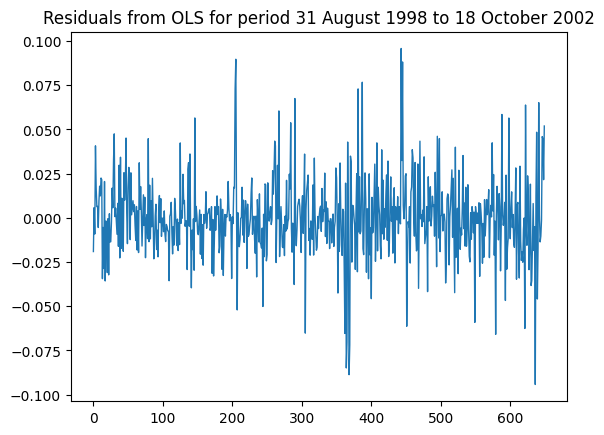

In [135]:
from statsmodels.formula.api import ols
S_col_name =\
    ['SMonRet', 'STueRet', 'SWedRet', 'SThuRet', 'SFriRet']
S_sorted_df, S_sorted_metrics, S_ols, S_gls, S_ols_hc, S_ols2=\
    MultiVar_Reg(LS_day, 4, list(range(5, 10)), S_col_name, 0.5)


In [136]:
S_sorted_metrics

,Mean,Std,t_value
SMonRet,-0.00751,0.03515,-3.43996
STueRet,-0.00072,0.02653,-0.43465
SWedRet,0.00132,0.02697,0.78923
SThuRet,0.00012,0.02553,0.07857
SFriRet,0.00119,0.0244,0.78487


### Q1

In [137]:
dummy_col = ['d1', 'd2', 'd3', 'd4', 'd5']
LSR =\
    pd.concat([LS_day[['LSR', 'STIR']], LS_day[dummy_col]], axis = 1)
SSR =\
    pd.concat([LS_day[['SSR', 'STIR']], LS_day[dummy_col]], axis = 1)
LSR.shape, SSR.shape

((1300, 7), (1300, 7))

In [138]:
LSR_dummy =\
    pd.DataFrame()
L_col_name =\
    ['LMonRet', 'LTueRet', 'LWedRet', 'LThuRet', 'LFriRet']
for d in dummy_col:
    temp_d =\
        LS_day.loc[~(LS_day[d]==0)]

    LSR_dummy[d] =\
        pd.DataFrame(temp_d['LSR'].values)

LSR_dummy.columns = L_col_name
LSR_dummy.head()

,LMonRet,LTueRet,LWedRet,LThuRet,LFriRet
0,NaN,-0.088550,0.053139,0.000000,0.002225
1,0.057976,0.003858,0.009763,-0.005668,-0.026350
2,0.000688,0.009770,-0.004191,-0.002842,0.014259
3,0.013696,-0.011126,-0.014777,-0.003199,0.011078
4,0.015035,-0.013439,0.004172,0.011725,-0.006701


In [139]:
SSR_dummy =\
    pd.DataFrame()
S_col_name =\
    ['SMonRet', 'STueRet', 'SWedRet', 'SThuRet', 'SFriRet']
for d in dummy_col:
    temp_d =\
        LS_day.loc[~(LS_day[d]==0)]

    SSR_dummy[d] =\
        pd.DataFrame(temp_d['SSR'].values)

SSR_dummy.columns = S_col_name
SSR_dummy.shape

(260, 5)

$$SE(Difference) = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$

In [140]:
q1_L_mean = LSR_dummy.dropna()['LMonRet'].mean()
q1_S_mean = SSR_dummy.dropna()['SMonRet'].mean()
q1_L_mean, q1_S_mean, q1_L_mean-q1_S_mean

(-0.0012650326486486486, -0.007514057169884171, 0.006249024521235522)

In [141]:
q1_SE =\
    np.sqrt(LSR_dummy.dropna()['LMonRet'].var()/len(LSR_dummy.dropna()) +\
            SSR_dummy.dropna()['SMonRet'].var()/len(SSR_dummy.dropna()))
q1_SE

0.002564940878424651

In [142]:
q1_t=(q1_L_mean-q1_S_mean)/q1_SE
q1_p =\
    2 * (1 - stats.t.cdf(abs(q1_t), df=len(LSR_dummy.dropna())-1))
q1_L_mean-q1_S_mean, q1_t, q1_p

(0.006249024521235522, 2.4363230255324955, 0.015514514680072589)

#### `ttest_ind` 是 `SciPy` 中的一个函数，用于执行独立样本 `t` 检验（Independent Samples T-test）
#### 独立样本 `t` 检验是一种用于比较两个独立样本均值是否显著不同的统计方法

In [143]:
from scipy.stats import ttest_ind
t_statistic, p_value =\
    ttest_ind(LSR_dummy['LMonRet'].dropna(), 
              SSR_dummy['SMonRet'].dropna(), 
              equal_var=True)
t_statistic,p_value

(2.436323025532494, 0.015174628227012599)

### Q2
这里我的ols formula没有减1，相当于回归有带上常数项，因为跟lecture code有不同，这里不只有dummy，还有多一个STIR自变量。不确定到底应该不应该减1

In [144]:
from statsmodels.formula.api import ols

Q2_L_formula = 'LSR ~ d1 + d2 + d3 + d4 + d5 + STIR'
# Q2_hypotheses_L = 'd1=d5, d2=d5, d3=d5, d4=d5, STIR=d5'
Q2_L_ols = ols(Q2_L_formula, LS_day.dropna()).fit()

Q2_S_formula = 'SSR ~ d1 + d2 + d3 + d4 + d5 + STIR'
# Q2_hypotheses_S = 'd1=d5, d2=d5, d3=d5, d4=d5, STIR=d5'
Q2_S_ols = ols(Q2_S_formula, LS_day.dropna()).fit()

In [145]:
Q2_L_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LSR   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     2022.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:34:06   Log-Likelihood:                 4866.9
No. Observations:                1299   AIC:                            -9722.
Df Residuals:                    1293   BIC:                            -9691.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      1.000      0.318      -0.000       0.000
d1             0.0001      0.000      0.419      0.675      -0.000       0.001
d2             0.0006      0.000      1.975      0.049     4.1e-06       0.001
d3         -6.194e-05      0.000     -0.194      0.846      -0.001       0.001
d4            -0.0003      0.000     -0.847      0.397      -0.001       0.000
d5            -0.0003      0.000     -0.937      0.349      -0.001       0.000
STIR           0.9224      0.009    100.462      0.000       0.904       0.940
==============================================================================
Omnibus:                      103.610   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.485
Skew:                           0.212   Prob(JB):                    1.13e-102
Kurtosis:                       5.915   Cond. No.                     6.64e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [146]:
Q2_S_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SSR   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     100.8
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           7.37e-90
Time:                        20:34:06   Log-Likelihood:                 3003.4
No. Observations:                1299   AIC:                            -5995.
Df Residuals:                    1293   BIC:                            -5964.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.001     -1.691      0.091      -0.002       0.000
d1            -0.0052      0.001     -3.859      0.000      -0.008      -0.003
d2             0.0002      0.001      0.123      0.902      -0.002       0.003
d3             0.0020      0.001      1.518      0.129      -0.001       0.005
d4             0.0006      0.001      0.426      0.670      -0.002       0.003
d5             0.0015      0.001      1.099      0.272      -0.001       0.004
STIR           0.8439      0.039     21.895      0.000       0.768       0.920
==============================================================================
Omnibus:                      148.392   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1299.616
Skew:                           0.051   Prob(JB):                    6.19e-283
Kurtosis:                       7.899   Cond. No.                     6.64e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

from above we observe:
* for LSR, d1 coef has no significance
* for SSR, d1 has significant negative coef

### Q3

In [147]:
Q3_top =\
    LSR.copy().dropna()
Q3_top.columns =\
    [['LS_combine', 'STIR']+ dummy_col]
Q3_top.tail()

,LS_combine,STIR,d1,d2,d3,d4,d5
1295,0.002468,0.003452,1,0,0,0,0
1296,0.033885,0.036498,0,1,0,0,0
1297,0.007196,0.006533,0,0,1,0,0
1298,0.019657,0.018568,0,0,0,1,0
1299,0.001367,-0.003163,0,0,0,0,1


In [148]:
Q3_bot =\
    SSR.copy().dropna()
Q3_bot.columns =\
    [['LS_combine', 'STIR']+ dummy_col]
Q3_bot.index = Q3_bot.index + len(Q3_top)
Q3_bot.tail()

,LS_combine,STIR,d1,d2,d3,d4,d5
2594,-0.007561,0.003452,1,0,0,0,0
2595,0.046484,0.036498,0,1,0,0,0
2596,0.042938,0.006533,0,0,1,0,0
2597,0.023428,0.018568,0,0,0,1,0
2598,0.050051,-0.003163,0,0,0,0,1


In [149]:
Q3_data =\
    pd.concat([Q3_top, Q3_bot])
Q3_data.tail()

,LS_combine,STIR,d1,d2,d3,d4,d5
2594,-0.007561,0.003452,1,0,0,0,0
2595,0.046484,0.036498,0,1,0,0,0
2596,0.042938,0.006533,0,0,1,0,0
2597,0.023428,0.018568,0,0,0,1,0
2598,0.050051,-0.003163,0,0,0,0,1


In [150]:
Q3_all_resid =\
    pd.concat([Q2_L_ols.resid, Q2_S_ols.resid])
Q3_all_resid.shape

(2598,)

In [151]:
Q2_resid_fit_L = sm.OLS(
    np.asarray(Q2_L_ols.resid)[1:], 
    sm.add_constant(np.asarray(Q2_L_ols.resid)[:-1])
).fit()
print(Q2_resid_fit_L.tvalues[1])
print(Q2_resid_fit_L.pvalues[1])
Q2_rho_L = Q2_resid_fit_L.params[1]
print(Q2_rho_L)

1.6916522439077533
0.09095270202736244
0.046949531723068


In [152]:
Q2_resid_fit_S = sm.OLS(
    np.asarray(Q2_S_ols.resid)[1:], 
    sm.add_constant(np.asarray(Q2_S_ols.resid)[:-1])
).fit()
print(Q2_resid_fit_S.tvalues[1])
print(Q2_resid_fit_S.pvalues[1])
Q2_rho_S = Q2_resid_fit_S.params[1]
print(Q2_rho_S)

-0.72842982967597
0.46648210424973346
-0.020265985499387445


In [153]:
Q2_trix_L = toeplitz(range(len(Q2_L_ols.resid)))
Q3_sigma1 = Q2_rho_L ** Q2_trix_L
Q2_trix_S = toeplitz(range(len(Q2_S_ols.resid)))
Q3_sigma2 = Q2_rho_S ** Q2_trix_S
Q3_sigma =\
    np.block([[Q3_sigma1, np.zeros_like(Q3_sigma1)], 
              [np.zeros_like(Q3_sigma2), Q3_sigma2]])

Q3_sigma1.shape, Q3_sigma2.shape, Q3_sigma.shape

((1299, 1299), (1299, 1299), (2598, 2598))

In [154]:
Dx = Q3_data.iloc[:,-5:]
Dx1 = Dx.copy()
Dx1['d1'] = 1
Dx1.rename(columns={'d1': 0}, inplace=True)
Dx1
Q3_gls_model =\
    sm.GLS(Q3_data['LS_combine'], Dx, sigma=Q3_sigma)
Q3_gls_results = Q3_gls_model.fit()
Q3_gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             LS_combine   R-squared:                       0.007
Model:                            GLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.740
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           0.000823
Time:                        20:34:08   Log-Likelihood:                 6090.7
No. Observations:                2598   AIC:                        -1.217e+04
Df Residuals:                    2593   BIC:                        -1.214e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0044      0.001     -4.321      0.000      -0.006      -0.002
d2            -0.0004      0.001     -0.390      0.696      -0.002       0.002
d3             0.0009      0.001      0.893      0.372      -0.001       0.003
d4             0.0003      0.001      0.283      0.777      -0.002       0.002
d5             0.0008      0.001      0.807      0.420      -0.001       0.003
==============================================================================
Omnibus:                      350.711   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4404.934
Skew:                           0.055   Prob(JB):                         0.00
Kurtosis:                       9.378   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
Dx = Q3_data.iloc[:,-6:]
Dx1 = Dx.copy()
Dx1['d1'] = 1
Dx1.rename(columns={'d1': 0}, inplace=True)
Dx1
Q3_gls_model =\
    sm.GLS(Q3_data['LS_combine'], Dx, sigma=Q3_sigma)
Q3_gls_results = Q3_gls_model.fit()
Q3_gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             LS_combine   R-squared:                       0.436
Model:                            GLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     401.4
Date:                Mon, 19 Feb 2024   Prob (F-statistic):          1.84e-319
Time:                        20:34:10   Log-Likelihood:                 6826.1
No. Observations:                2598   AIC:                        -1.364e+04
Df Residuals:                    2592   BIC:                        -1.361e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.8830      0.020     44.425      0.000       0.844       0.922
d1            -0.0029      0.001     -3.817      0.000      -0.004      -0.001
d2         -9.354e-05      0.001     -0.122      0.903      -0.002       0.001
d3             0.0005      0.001      0.716      0.474      -0.001       0.002
d4            -0.0002      0.001     -0.297      0.767      -0.002       0.001
d5          7.262e-05      0.001      0.095      0.925      -0.001       0.002
==============================================================================
Omnibus:                      496.391   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13762.676
Skew:                          -0.056   Prob(JB):                         0.00
Kurtosis:                      14.275   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q4

In [156]:
bp_test = het_breuschpagan(Q3_gls_results.resid,Dx1)
print ('BP LM-test chi-sq:', bp_test[0], 'BP LM-test p_value:', bp_test[1])
wh_test = het_white(Q3_gls_results.resid**2, Dx)
print ('WT LM-test chi-sq:', wh_test[0], 'WT LM-test p_value:', wh_test[1])

BP LM-test chi-sq: 7.020504713981373 BP LM-test p_value: 0.21911980789113392
WT LM-test chi-sq: 11.666523329389676 WT LM-test p_value: 0.307994591690133


### Q3 Q4 (Alternative) 
不像lecture里，他当时有说残差里有时间序列相关性，所以有求了$\rho$，这里只是放了相同的方差值当作GLS里的$\Sigma$

In [157]:
Q3_top =\
    LSR.copy().dropna()
Q3_top.columns =\
    [['LS_combine', 'STIR']+ dummy_col]
Q3_bot =\
    SSR.copy().dropna()
Q3_bot.columns =\
    [['LS_combine', 'STIR']+ dummy_col]
Q3_bot.index = Q3_bot.index + len(Q3_top)
Q3_data =\
    pd.concat([Q3_top, Q3_bot])
Q3_data.tail()

,LS_combine,STIR,d1,d2,d3,d4,d5
2594,-0.007561,0.003452,1,0,0,0,0
2595,0.046484,0.036498,0,1,0,0,0
2596,0.042938,0.006533,0,0,1,0,0
2597,0.023428,0.018568,0,0,0,1,0
2598,0.050051,-0.003163,0,0,0,0,1


In [158]:
Q2_var_l = np.var(Q2_L_ols.resid)
Q2_var_s = np.var(Q2_S_ols.resid)

In [159]:
Dx = Q3_data.iloc[:,-6:]
Dx1 = Dx.copy()
Dx1['d1'] = 1
Dx1.rename(columns={'d1': 0}, inplace=True)
# Dx1 = sm.add_constant(Dx)
Dx1.head()

,STIR,0,d2,d3,d4,d5
1,-0.096719,1,1,0,0,0
2,0.066769,1,0,1,0,0
3,0.000000,1,0,0,1,0
4,0.020108,1,0,0,0,1
5,0.069216,1,0,0,0,0


In [160]:
Q3_ols_model_new = sm.OLS(Q3_data['LS_combine'], Dx1)
Q3_ols_results_new = Q3_ols_model_new.fit()
Q3_ols_new_residuals = Q3_ols_results_new.resid
Q3_ols_results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LS_combine   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     401.7
Date:                Mon, 19 Feb 2024   Prob (F-statistic):          1.17e-319
Time:                        20:34:10   Log-Likelihood:                 6824.4
No. Observations:                2598   AIC:                        -1.364e+04
Df Residuals:                    2592   BIC:                        -1.360e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.8831      0.020     44.441      0.000       0.844       0.922
              -0.0029      0.001     -3.795      0.000      -0.004      -0.001
d2             0.0029      0.001      2.682      0.007       0.001       0.005
d3             0.0035      0.001      3.221      0.001       0.001       0.006
d4             0.0027      0.001      2.453      0.014       0.001       0.005
d5             0.0031      0.001      2.853      0.004       0.001       0.005
==============================================================================
Omnibus:                      493.620   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13467.118
Skew:                          -0.058   Prob(JB):                         0.00
Kurtosis:                      14.153   Cond. No.                         62.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
Q3_weights_matrix =\
    np.diag(np.concatenate((np.repeat(Q2_var_l,
                                      len(LSR.dropna())),
                            np.repeat(Q2_var_s,
                                      len(SSR.dropna())))))
# np.concatenate 函数需要接收一个序列作为参数
Q3_gls_model_1 =\
    sm.GLS(Q3_data['LS_combine'], Dx, sigma=Q3_weights_matrix)
Q3_gls_results_1 = Q3_gls_model_1.fit()
Q3_gls_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             LS_combine   R-squared:                       0.802
Model:                            GLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     2106.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:34:11   Log-Likelihood:                 7859.2
No. Observations:                2598   AIC:                        -1.571e+04
Df Residuals:                    2592   BIC:                        -1.567e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.9182      0.009    102.483      0.000       0.901       0.936
d1         -7.649e-05      0.000     -0.220      0.826      -0.001       0.001
d2             0.0007      0.000      1.960      0.050    -1.9e-07       0.001
d3             0.0001      0.000      0.362      0.718      -0.001       0.001
d4            -0.0002      0.000     -0.433      0.665      -0.001       0.001
d5            -0.0001      0.000     -0.372      0.710      -0.001       0.001
==============================================================================
Omnibus:                      247.288   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1707.669
Skew:                           0.109   Prob(JB):                         0.00
Kurtosis:                       6.966   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
Q3_HC3_model_1 = sm.OLS(Q3_data['LS_combine'], Dx1)
Q3_ols_hc_new = Q3_HC3_model_1.fit(cov_type="HC3")
Q3_ols_hc_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LS_combine   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     232.3
Date:                Mon, 19 Feb 2024   Prob (F-statistic):          2.35e-205
Time:                        20:34:11   Log-Likelihood:                 6824.4
No. Observations:                2598   AIC:                        -1.364e+04
Df Residuals:                    2592   BIC:                        -1.360e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.8831      0.027     32.835      0.000       0.830       0.936
              -0.0029      0.001     -3.228      0.001      -0.005      -0.001
d2             0.0029      0.001      2.512      0.012       0.001       0.005
d3             0.0035      0.001      3.001      0.003       0.001       0.006
d4             0.0027      0.001      2.256      0.024       0.000       0.005
d5             0.0031      0.001      2.685      0.007       0.001       0.005
==============================================================================
Omnibus:                      493.620   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13467.118
Skew:                          -0.058   Prob(JB):                         0.00
Kurtosis:                      14.153   Cond. No.                         62.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [163]:
# from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(np.square(Q3_gls_results_1.resid),Dx1)
print ('LM-test chi-sq:', bp_test[0], 'LM-test p_value:', bp_test[1])

LM-test chi-sq: 7.67452407988211 LM-test p_value: 0.17510902546209925


In [164]:
# from statsmodels.stats.diagnostic import het_white
wh_test = het_white(Q3_gls_results_1.resid**2,Dx)
print ('WH-test chi-sq:', wh_test[0], 'WH-test p_value:', wh_test[1])

WH-test chi-sq: 12.192829927019934 WH-test p_value: 0.27235843125792636


### Q5
像是第5题有明确说$\rho$的相关性，所以$\Sigma$的cov matrix要先求残差中$\rho$的值，跟Q3 alternative里的理解方向是不同的，所以可能Q3本来是没有$\rho$相关的

In [165]:
Q2_L_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LSR   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     2022.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:34:11   Log-Likelihood:                 4866.9
No. Observations:                1299   AIC:                            -9722.
Df Residuals:                    1293   BIC:                            -9691.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      1.000      0.318      -0.000       0.000
d1             0.0001      0.000      0.419      0.675      -0.000       0.001
d2             0.0006      0.000      1.975      0.049     4.1e-06       0.001
d3         -6.194e-05      0.000     -0.194      0.846      -0.001       0.001
d4            -0.0003      0.000     -0.847      0.397      -0.001       0.000
d5            -0.0003      0.000     -0.937      0.349      -0.001       0.000
STIR           0.9224      0.009    100.462      0.000       0.904       0.940
==============================================================================
Omnibus:                      103.610   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.485
Skew:                           0.212   Prob(JB):                    1.13e-102
Kurtosis:                       5.915   Cond. No.                     6.64e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [166]:
LSR.head()

,LSR,STIR,d1,d2,d3,d4,d5
0,NaN,NaN,1,0,0,0,0
1,-0.088550,-0.096719,0,1,0,0,0
2,0.053139,0.066769,0,0,1,0,0
3,0.000000,0.000000,0,0,0,1,0
4,0.002225,0.020108,0,0,0,0,1


In [167]:
Q5_gls_model =\
    sm.GLS(LSR.dropna()['LSR'], LSR.dropna().iloc[:,-6], sigma=Q3_sigma1)
Q5_gls_results = Q5_gls_model.fit()
Q5_gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                    LSR   R-squared (uncentered):                   0.885
Model:                            GLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                          1.004e+04
Date:                Mon, 19 Feb 2024   Prob (F-statistic):                        0.00
Time:                        20:34:11   Log-Likelihood:                          4865.6
No. Observations:                1299   AIC:                                     -9729.
Df Residuals:                    1298   BIC:                                     -9724.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.9216      0.009    100.179      0.000       0.904       0.940
==============================================================================
Omnibus:                      105.229   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.397
Skew:                           0.205   Prob(JB):                    1.97e-107
Kurtosis:                       5.985   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
q5_model_hc = sm.OLS(LSR.dropna()['LSR'], LSR.dropna().iloc[:,-6])
q5_ols_hc = q5_model_hc.fit(cov_type="HC3")
q5_ols_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    LSR   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              4360.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):                        0.00
Time:                        20:34:11   Log-Likelihood:                          4864.1
No. Observations:                1299   AIC:                                     -9726.
Df Residuals:                    1298   BIC:                                     -9721.
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
STIR           0.9218      0.014     66.028      0.000       0.894       0.949
==============================================================================
Omnibus:                      103.148   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.001
Skew:                           0.207   Prob(JB):                    1.44e-102
Kurtosis:                       5.915   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

#### Homework 3:
1. A 0.006249024521235522, 2.4363230255324955, 0.015514514680072589
2. C SSR - negative Monday, LSR - no significance
3. <span style="color: red;"> B -0.000, -0.220  (coef=-7.649e-05 , t=-0.220) </span>
4. B 7.57, 12.38 (t_bp=7.67452407988211, t_white=12.192829927019934)
5. C 1.9, 2.0 (ols: 1.906, gls: 1.994)

## <a id = "p5"> Lecture 5. </a> Cross-Section Regression [back to table of contents](#top)

In [169]:
# import scipy as sp
# import scipy.stats
# import statsmodels.api as sm
# import datetime as dt

#### Data Exercise on Estimation of Risk Premia
Read the background paper by Jonathan Lewellen, (2015), “The cross section of expected stock returns”, Critical Finance Review, pp. 1-44, and also Fama and French (1992) covered in class. You can also check up Predicting Stock Returns Using Firm Characteristics - (alphaarchitect.com) Data set GPEX1set1.csv obtained via from WRDS contains 2,290,809 rows and 6 columns viz. GVKEY (firm identifier), Date, Return (monthly return rate % of firm's stock), Log market value of equity at the end of the prior month, Log book value of equity minus log market value of equity at the end of the prior month, Stock return from month −12 to month −2 earlier. The rows are arranged by firms, then by dates. Note that different firms’ data may start and end at different dates.

* In Q1, we find and report the time series of each monthly cross-sectional regression estimates for the entire data set. The regressand is stock return and the regressors are the given 3 firm's characteristics. Use a constant for the regression. Ignore months when the number of firms for cross-sectional regression is less than the threshold of 30.

* In Q2, compute the time series averages of the slope estimates (risk premium estimates each month) and their standard errors. This follows the Fama-MacBeth procedure. Hence perform a t-test if the slope average is significantly different from zero.

##### <a id = "p51"> </a> 5.1 function definition [back to table of contents](#top)

In [170]:
def cs_ols(df, keys_Nloc_list, Date_Nloc, values_Nloc_list, threshold=30):
    cs_stats = []
    cs_result = {}
    
    idx =\
        list(df.columns[keys_Nloc_list])
    ret =\
        list(df.columns[values_Nloc_list])
    dates =\
        df.columns[Date_Nloc]
    df[dates] =\
        pd.to_datetime(df[dates])
    df =\
       df.set_index(idx) 
    
    for dates, datapoints in df.groupby(dates):

        if datapoints.count().min() >= threshold:        
            OLS = sm.OLS(datapoints[ret[0]], sm.add_constant(datapoints.iloc[:,1:])).fit()
            OLS_stats = OLS.params 
            OLS_stats.name = dates
            OLS_stats['Adj $\mathbb{R}^2$'] = OLS.rsquared_adj
            OLS_stats['N.Obs'] = OLS.nobs
            cs_stats.append(OLS_stats)
            cs_result[dates.strftime('%Y-%m-%d')] = OLS
    
    cs_stats = pd.DataFrame(cs_stats)   
    
    mean = cs_stats.iloc[:, :-2].mean()
    std = cs_stats.iloc[:, :-2].std()
    nobs = len(cs_stats)
    tstat = mean / (std / np.sqrt(nobs))    

    df_t1 = pd.concat([mean, tstat], axis=1)
    df_t1.columns = ['average', 't-statistic']
    df_t1['p-value'] = scipy.stats.t.sf(abs(tstat), df=len(cs_stats)-1)*2
    # above p-value for two-tailed t-test
    print('No. of Obs:',nobs)
    
    
    return cs_stats, df_t1 

##### <a id = "p52"> </a>5.2 Results [back to table of contents](#top)

In [171]:
GP = pd.read_csv('GPEX1set1.csv')
GP['Return'] = GP['Return']/100
print(GP.shape)
GP.head(5)

(2290809, 6)


,GVKEY,Date,Return,LogSize_-1,LogB/M_-1,"Return_-2,-12"
0,1000,1972-04-30,0.266667,2.819480,-0.266121,-0.461539
1,1000,1972-05-31,-0.070175,3.053069,-0.934455,-0.476744
2,1000,1972-06-30,-0.094340,2.977503,-0.861695,-0.173913
3,1000,1972-07-31,0.000000,2.875596,-0.762604,-0.196970
4,1000,1972-08-31,-0.020833,2.875935,-0.762604,-0.020408


In [172]:
# def cs_ols(df, keys_Nloc_list, Date_Nloc, values_Nloc_list, threshold=30):
idx_Nloc_list=[1, 0]
ret_Nloc_list=list(range(2, 6))
idx_Nloc_list,ret_Nloc_list

GPEX1_summary,GPEX1_results =\
    cs_ols(GP,idx_Nloc_list, 1, ret_Nloc_list, threshold=30)

No. of Obs: 648


In [173]:
GPEX1_summary.head(3)

,const,LogSize_-1,LogB/M_-1,"Return_-2,-12",Adj $\mathbb{R}^2$,N.Obs
1967-04-30,-0.007385,-0.000439,0.004839,0.127069,0.260407,39.0
1967-05-31,-0.036995,0.001527,-0.007863,-0.146485,0.169260,41.0
1967-06-30,0.168175,-0.027092,-0.002100,0.027267,0.052855,42.0


In [174]:
GPEX1_summary.tail(3)

,const,LogSize_-1,LogB/M_-1,"Return_-2,-12",Adj $\mathbb{R}^2$,N.Obs
2021-01-31,0.220899,-0.016224,0.067245,0.297142,0.042235,1173.0
2021-02-28,0.194326,-0.007977,0.039267,0.019392,0.061897,1004.0
2021-03-31,0.070153,0.001472,0.020264,-0.013328,0.046385,923.0


In [175]:
GPEX1_results

,average,t-statistic,p-value
const,0.017795,5.582568,3.489432e-08
LogSize_-1,-0.001086,-2.930760,3.500591e-03
LogB/M_-1,0.004723,7.565198,1.335177e-13
"Return_-2,-12",0.009976,6.626166,7.259303e-11


## <a id = "p6"> Lecture 6. </a> Euler Equation and Generalized Method of Moments [back to table of contents](#top)

##### <a id = "p61"> </a> 6.1 function definition [back to table of contents](#top)

In [176]:
class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog.squeeze()
        inst = self.instrument   

        error1 = endog - p0 - p1 * exog
        error2 = (endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)
        error3 = (endog - p0 - p1 * exog) * inst[:,1]
        error4 = ((endog - p0 - p1 * exog) ** 2 - p2 * (1/365) * (exog ** p3)) * inst[:,1]
        error5 = (endog - p0 - p1 * exog) * (inst[:,1])**2
        
#         if self.nmoms == 1:
#             return error1[:, np.newaxis]
        if self.nmoms == 2:
            return np.column_stack((error1, error2))
        elif self.nmoms == 3:
            return np.column_stack((error1, error2, error3))
        elif self.nmoms == 4:
            return np.column_stack((error1, error2, error3, error4))
        elif self.nmoms == 5:
            return np.column_stack((error1, error2, error3, error4, error5))
         
#         g = np.column_stack((error1, error2, error3, error4))        
#         return g

In [177]:
def get_gmm_result(SR, N_mmt, initial0=np.array([0.1, 0.1, 1, 1])):    
    SR1 = SR.shift(1)[1:]
    DSR = SR.diff()[1:]
    inst = np.column_stack((np.ones(len(SR1)), SR1)) 
    
    results =\
        gmm(endog = DSR, 
            exog = SR1, 
            instrument = inst,
            k_moms=N_mmt,
            k_params=4)\
    .fit(initial0)
    coefs =\
        results.params
#     mod =\
#         gmm(endog = DSR, 
#             exog = SR1, 
#             instrument = inst, 
#             k_moms=N_mmt, 
#             k_params=4)
#     print(mod.momcond(initial0).shape)
    
    alpha=coefs[0]/(1/365)
    beta=-coefs[1]/(1/365) 
    ### Note this is weakest - not significantly diff from zero. 
    ### More like Dothan's model
    sigma=np.sqrt(coefs[2])
    lambda1 = coefs[3]/2

    metric =\
        pd.DataFrame({f'GMM_{N_mmt}': [alpha, beta, sigma, lambda1]})
    metric.index =\
        ['alpha', 'beta', 'sigma', 'lambda']
    return results, metric
    

##### <a id = "p62"> </a> 6.2 Results [back to table of contents](#top)

In [178]:
IR = pd.read_csv('Interest_Rate.csv')
### We assume 4-week riskfree rates p.a. in 2021 approx the riskfree short-rate p.a.
DY=IR['4 WEEKS BANK DISCOUNT']  ### DY is annualized discount yield
### convert this DY to annualized spot rate SR (BEY)
###   discounted bill price P = 1-DY/12. SR approx by BEY = (1/p - 1) x 12 x 365/360. Hence.
Srs=365*DY/(360*(1-DY/12))

In [179]:
ir_gmm4, ir_gmm4_metrics =\
    get_gmm_result(Srs, 4)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [180]:
ir_gmm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   gmm Results                                   
=================================================================================
Dep. Variable:     4 WEEKS BANK DISCOUNT   Hansen J:                    3.842e-11
Model:                               gmm   Prob (Hansen J):                   nan
Method:                              GMM                                         
Date:                   Mon, 19 Feb 2024                                         
Time:                           20:34:15                                         
No. Observations:                    488                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0            0.0052      0.002      2.311      0.021       0.001       0.010
p 1            0.0060      0.004      1.479      0.139      -0.002       0.014
p 2            3.4160      0.555      6.155      0.000       2.328       4.504
p 3            0.7662      0.108      7.119      0.000       0.555       0.977
==============================================================================
"""

In [181]:
ir_gmm4_metrics

,GMM_4
alpha,1.881552
beta,-2.195207
sigma,1.848231
lambda,0.383120


In [182]:
ir_gmm5, ir_gmm5_metrics =\
    get_gmm_result(Srs, 5)

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.009094
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.008856
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.008837
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.008836
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.008835
         Iterations: 6
         Function evaluations: 10
      

In [183]:
ir_gmm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   gmm Results                                   
=================================================================================
Dep. Variable:     4 WEEKS BANK DISCOUNT   Hansen J:                        4.312
Model:                               gmm   Prob (Hansen J):                0.0379
Method:                              GMM                                         
Date:                   Mon, 19 Feb 2024                                         
Time:                           20:34:15                                         
No. Observations:                    488                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0            0.0019      0.002      1.183      0.237      -0.001       0.005
p 1            0.0065      0.004      1.604      0.109      -0.001       0.014
p 2            2.6468      0.476      5.557      0.000       1.713       3.580
p 3            0.8516      0.140      6.080      0.000       0.577       1.126
==============================================================================
"""

In [184]:
ir_gmm5.jtest()

(4.311648277715763, 0.03785226918077946, 1)

In [185]:
#find Chi-Square critical value
scipy.stats.chi2.ppf(1-.03785, df=1)

4.3117502675445145

##### <a id = "p63"> </a> 6.3 Homework 4 [back to table of contents](#top)

In [186]:
class hw4_gmm(GMM):
    def momcond(self, params):
        p0, p1, = params 
        # rho and delta, where delta = gamma - 1
        endog = self.endog
        exog = self.exog.squeeze()
        inst = self.instrument   

        error1 =\
            p0 *\
            endog *\
            exog ** p1\
            - 1
        
        error2 =\
            (p0 *\
            endog *\
            exog ** p1\
            - 1) * inst.iloc[:,0]
        
        error3 =\
            (p0 *\
            endog *\
            exog ** p1\
            - 1) * inst.iloc[:,1]
            
        g = np.column_stack((error1, error2, error3))
        return g

In [187]:
consumer =\
    pd.read_csv('cons.csv', 
                index_col=0)
Ct =\
    consumer.iloc[:,-1]
Qt_p1 =\
    Ct / Ct.shift(1)
marketrr =\
    pd.read_csv("mktretrate1990-2010.csv", 
                index_col = 0)
Rt_p1 =\
    marketrr.iloc[:,-1]\
    .apply(lambda x: np.exp(x))

Rt = Rt_p1.shift(1)
Rt_m1 = Rt_p1.shift(2)
hw4_data =\
    pd.DataFrame({'Cons': Ct, 
                  'Qt+1': Qt_p1,
                  'Rt+1': Rt_p1,
                  'Rt': Rt,
                  'Rt-1': Rt_m1})

print(hw4_data.isna().sum())
hw4_gmm_data =\
    hw4_data.dropna()
print(hw4_gmm_data.shape)
hw4_gmm_data.head()

Cons    0
Qt+1    1
Rt+1    0
Rt      1
Rt-1    2
dtype: int64
(79, 5)


,Cons,Qt+1,Rt+1,Rt,Rt-1
Date,,,,,
1/7/1990,24150,1.000414,1.076632,1.005227,0.966859
1/10/1990,23882,0.988903,0.853573,1.076632,1.005227
1/1/1991,23719,0.993175,1.131349,0.853573,1.076632
1/4/1991,23839,1.005059,1.091327,1.131349,0.853573
1/7/1991,23873,1.001426,1.033223,1.091327,1.131349


In [188]:
hw4_initial = [1, -1.3]
hw4_results =\
    hw4_gmm\
    (
        endog = hw4_gmm_data['Rt+1'],
        exog = hw4_gmm_data['Qt+1'],
        instrument = hw4_gmm_data[['Rt', 'Rt-1']],
        k_moms=3,
        k_params=2
    ).fit(hw4_initial)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 3
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


### Q1 Q2 Q3
* p0, p1, = params 
* p0 = $\rho$
* p1 = $\delta$ = $\gamma - 1$
* Relative risk aversion coefficient estimate is 1 − $\gamma$ = −$\delta$

In [189]:
hw4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               hw4_gmm Results                                
==============================================================================
Dep. Variable:                   Rt+1   Hansen J:                     0.002569
Model:                        hw4_gmm   Prob (Hansen J):                 0.960
Method:                           GMM                                         
Date:                Mon, 19 Feb 2024                                         
Time:                        20:34:15                                         
No. Observations:                  79                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0            1.0154      0.028     35.956      0.000       0.960       1.071
p 1           -7.3142      5.408     -1.352      0.176     -17.914       3.286
==============================================================================
"""

In [190]:
hw4_rho = hw4_results.params[0]
hw4_delta = hw4_results.params[1]
hw4_results.params

array([ 1.01538094, -7.31416361])

$$z = \frac{\hat{\rho} - \rho_0}{\sigma_{ \hat{\rho}}}$$

In [191]:
# Calculate the z-test statistic for null that rho = 1.0
z_test_statistic = (hw4_rho - 1.0) / (0.028)

# Calculate the p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z_test_statistic)))

# Print the results
print("Z-test Statistic:", z_test_statistic)
print("P-value:", p_value)

Z-test Statistic: 0.5493193189529677
P-value: 0.5827863317084252


### Q4
* GMM is most generalized, thus autocorrelation share not play a part

### Q5
* Wrong specification

#### Homework 4:
1. C 1.02, 0.55 (p0 = 1.01538094, z-value for rho=1 is 0.5827863317084252)
2. A 7.3, 5.4 (Relative risk aversion coefficient = -p1 = -(-7.3142), std = 5.408)
3. A 0.0026, 0.96 (J-statistic = 0.002569, p-value = 0.960)
4. B Similar estimates (GMM is most generalized)
5. A Wrong Specification

## <a id = "p7"> Lecture 7. </a> Maximum Likelihood Method and GARCH [back to table of contents](#top)

### Note: $$ y_t∼N(μ,σ_t^2)$$  $$σ_t^2 = ω + α ϵ_{t-1}^2 + β σ_{t−1}^2$$
 For more variations in forecasting see https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
* Rolling Predictions: At this point, we have developed a GARCH model that can forecast S&P500 index return volatility. We can now put our model to the test using historical data from the n-period of time in a rolling prediction process. 
* Create a training set in a loop using the daily return rates from the ith day to the (i + trgset size)th day. 
* In each loop, the current training set is used to train a GARCH (1,1) model with the parameters p and q set to 1. 
* The current model forecasts next day volatility with a 1-time step (horizon=1 day). The result (standard deviation) is appended to the rolling predictions. 
* The rolling window for estimation then shifts to trg set (i+1)th to (i + 1 + trgset size)th day. The next 1-time step ahead volatility is predicted and added to the rolling predictions variable.

In [192]:
# !pip3 install arch
# from arch import arch_model
# from arch.__future__ import reindexing

##### <a id = "p71"> </a> 7.1 function definition [back to table of contents](#top)

In [193]:
def GARCH(PctRet, trgset_size, h=10):
    daily_volatility =\
        PctRet.std()
    monthly_volatility =\
        np.sqrt(21) * daily_volatility
    annual_volatility =\
        np.sqrt(252) * daily_volatility    
    Vol_table =\
        pd.DataFrame({'Asset Vol in %': 
                      [daily_volatility,
                       monthly_volatility,
                       annual_volatility]})
    Vol_table.index =\
        ['Daily', 'Monthly', 'Annually']    
    
    Ntot = len(PctRet)
    
    model_all =\
        arch_model(PctRet, p=1, q=1,
                   mean = 'constant',
                   vol = 'GARCH',
                   dist = 'normal')
    model_fit_all = model_all.fit(disp='off')    

    print(model_fit_all.params)
    print('\n')  ### print new line
    gm_all_forecast =\
        model_fit_all.forecast(horizon = h)
    print(gm_all_forecast.variance.head())     
    

    if Ntot <= trgset_size:
        print("Not Enough Data Entry!")
        return model_all, Vol_table
    
    rolling_predictions = []
    for i in range(Ntot-trgset_size):
        train = PctRet[i:i+trgset_size]
#         model = arch_model(train, p=1, q=1)
        model = arch_model(train, p=1, q=1,
                           mean = 'constant',
                           vol = 'GARCH',
                           dist = 'normal')
        model_fit = model.fit(disp='off')

        pred = model_fit.forecast(horizon=1)
        rolling_predictions\
            .append(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_predictions =\
        pd.Series(rolling_predictions, 
                  index=PctRet.index[-(Ntot-trgset_size):])
    fig,ax = plt.subplots(figsize=(13,4))
    ax.grid(which="major", 
            axis='y', 
            color='#758D99', 
            alpha=0.3, 
            zorder=1)
    ax.spines[['top','right']].set_visible(False)
    
    plt.plot(rolling_predictions)
#     plt.plot(PctRet[-(Ntot-trgset_size):]) 
    plt.plot(PctRet[-(Ntot-trgset_size):]*.25+1.5) 
#     ### Affine-transformed to compare the trends     
    plt.title('GARCH Rolling Prediction of daily in %')
    plt.legend(['Predicted Daily Volatility in %',
                'Daily Return Rate in %'])
    plt.show()
    return model_fit_all, Vol_table

##### <a id = "p72"> </a> 7.2 Results [back to table of contents](#top)

In [194]:
spx =\
    pd.read_csv('S&P500_Yahoo_Finance.csv')
spx.tail()

,Date,Open,High,Low,Close*,Adj Close**,Volume,SP_RET
10875,"Jan 08, 1980",0,109.29,106.29,108.95,108.95,"53,390,000",0.019838
10876,"Jan 07, 1980",0,107.8,105.8,106.81,106.81,"44,500,000",0.002719
10877,"Jan 04, 1980",0,107.08,105.09,106.52,106.52,"39,130,000",0.012279
10878,"Jan 03, 1980",0,106.08,103.26,105.22,105.22,"50,480,000",-0.005119
10879,"Jan 02, 1980",0,108.43,105.29,105.76,105.76,"40,610,000",NaN


In [195]:
spx_reidx = spx[::-1]
spx_reidx.reset_index(inplace=True, drop=True)
spx_reidx=spx_reidx.dropna()

In [196]:
### Select only the subperiod 3 Jan 2022 to 30 Dec 2022 
### for analysis (251 data points)
spx_reidx1=spx_reidx.iloc[10591:10842,:]
DayPctRet =\
    spx_reidx1.iloc[:,-1] * 100

mu         -0.095182
omega       0.078652
alpha[1]    0.000000
beta[1]     0.968090
Name: params, dtype: float64


           h.01      h.02      h.03      h.04      h.05     h.06      h.07  \
10842  2.464524  2.464534  2.464543  2.464553  2.464562  2.46457  2.464579   

           h.08      h.09      h.10  
10842  2.464587  2.464595  2.464603  


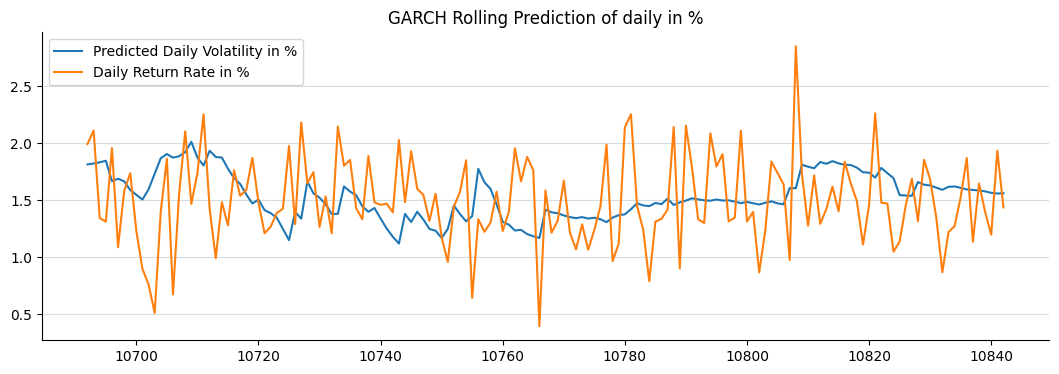

In [197]:
spx_garch, spx_vol =\
    GARCH(DayPctRet, 100, 10)

In [198]:
spx_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 SP_RET   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -459.795
Distribution:                  Normal   AIC:                           927.590
Method:            Maximum Likelihood   BIC:                           941.691
                                        No. Observations:                  251
Date:                Mon, Feb 19 2024   Df Residuals:                      250
Time:                        20:34:15   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0952  9.513e-02     -1.001      0.317 [ -0.282,9.127e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0787  7.724e-02      1.018      0.309   [-7.274e-02,  0.230]
alpha[1]       0.0000  3.548e-02      0.000      1.000 [-6.953e-02,6.953e-02]
beta[1]        0.9681  6.782e-02     14.274  3.168e-46      [  0.835,  1.101]
=============================================================================

Covariance estimator: robust
"""

In [199]:
spx_vol

,Asset Vol in %
Daily,1.523902
Monthly,6.983395
Annually,24.191191


## <a id = "p8"> Lecture 8. </a> Unit Roots and Cointegration [back to table of contents](#top)

In [200]:
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

##### <a id = "p81"> </a> 8.1 function definition [back to table of contents](#top)

In [201]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    print('ADF Statistic: %f' % adf)
    print('p-value: %f' % pvalue)
    
    critical_value = dftest[4]['10%']
    if (pvalue < 0.10) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [202]:
def Coint_test(list_of_data, const, lags):
    data=pd.DataFrame()
    for d in list_of_data:
        data=pd.concat([data,pd.DataFrame(d)],axis=1)
    coint = coint_johansen(data, const, lags) 
# 2nd argument: -1 (no deterministic term), 0 (constant), 1 (linear trend)
# 3rd argument: number of lagged differences
    return coint

##### <a id = "p82"> </a> 8.2 Results [back to table of contents](#top)

In [203]:
UKUS_all =\
    pd.read_csv('POUND_USD.csv') ### need to ensure numbers are in numbers, not general or other formats in CSV
print(UKUS_all.shape)
UKUS_all=UKUS_all.dropna()
print(UKUS_all.shape)
UKUS_all.head()

(5995, 2)
(5995, 2)


,Date,Pound_USD
0,3/1/2000,1.6270
1,4/1/2000,1.6370
2,5/1/2000,1.6415
3,6/1/2000,1.6475
4,7/1/2000,1.6384


In [204]:
UKUS_all[["day", "month", "year"]] =\
    UKUS_all["Date"].str.split("/", expand = True) 
### Splits the Date entry into 3 separate columns
print("\nNew DataFrame:") 
UKUS_all.head()
### Note this split command does not work 
###  if ...parse_dates=['date']... is entered into the pd.read_csv(..)


New DataFrame:


,Date,Pound_USD,day,month,year
0,3/1/2000,1.6270,3,1,2000
1,4/1/2000,1.6370,4,1,2000
2,5/1/2000,1.6415,5,1,2000
3,6/1/2000,1.6475,6,1,2000
4,7/1/2000,1.6384,7,1,2000


In [205]:
UKUS_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5995 entries, 0 to 5994
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5995 non-null   object
 1   Pound_USD  5995 non-null   object
 2   day        5995 non-null   object
 3   month      5995 non-null   object
 4   year       5995 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [206]:
UKUS_all = UKUS_all[UKUS_all['Pound_USD'] != 'ND']
print(UKUS_all.shape)
UKUS_all = UKUS_all[UKUS_all['Pound_USD'] != 'N']
print(UKUS_all.shape)
for col in UKUS_all.columns[1:]:
    UKUS_all[col] =\
        UKUS_all[col].astype(float)
UKUS_all.info()

(5765, 5)
(5764, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 5764 entries, 0 to 5994
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5764 non-null   object 
 1   Pound_USD  5764 non-null   float64
 2   day        5764 non-null   float64
 3   month      5764 non-null   float64
 4   year       5764 non-null   float64
dtypes: float64(4), object(1)
memory usage: 270.2+ KB


In [207]:
UKUS_all.tail()

,Date,Pound_USD,day,month,year
5990,19/12/2022,1.2180,19.0,12.0,2022.0
5991,20/12/2022,1.2146,20.0,12.0,2022.0
5992,21/12/2022,1.2072,21.0,12.0,2022.0
5993,22/12/2022,1.2032,22.0,12.0,2022.0
5994,23/12/2022,1.2054,23.0,12.0,2022.0


In [208]:
### Select only end of month exchange rates
exch = pd.DataFrame()
end_of_month =\
    UKUS_all\
    .groupby(['year', 'month'])['day']\
    .max()\
    .reset_index()
exch =\
    pd.merge(UKUS_all, 
             end_of_month, 
             on=['year', 'month', 'day'], 
             how='inner')

exch =\
    exch[(exch['year'] >= 2000) & 
         (exch['year'] <= 2021)]
print(exch.shape)
exch_UKUS=exch['Pound_USD']

(264, 5)


In [209]:
dfUS =\
    pd.read_csv('US_CPI.csv') 
### need to ensure numbers are in numbers, 
###  not general or other formats in CSV
dfUS=dfUS.dropna()
dfUS.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
35,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524
36,2018,247.867,248.991,249.554,250.546,251.588,251.989,252.006,252.146,252.439,252.885,252.038,251.233
37,2019,251.712,252.776,254.202,255.548,256.092,256.143,256.571,256.558,256.759,257.346,257.208,256.974
38,2020,257.971,258.678,258.115,256.389,256.394,257.797,259.101,259.918,260.280,260.388,260.229,260.474
39,2021,261.582,263.014,264.877,267.054,269.195,271.696,273.003,273.567,274.310,276.589,277.948,278.802


In [210]:
US_CPI_col =\
    dfUS[(dfUS['Year']>=2000) & (dfUS['Year']<=2021)]\
    .iloc[:,1:]\
    .values\
    .flatten()

In [211]:
dfUK =\
    pd.read_csv('UK_CPI.csv') ### need to ensure numbers are in numbers, not general or other formats in CSV
dfUK=dfUK.dropna()
UK_CPI_col =\
    dfUK[(dfUK['Year']>=2000) & (dfUK['Year']<=2021)]\
    .iloc[:,1:]\
    .values\
    .flatten()

exch_UKUS.shape, US_CPI_col.shape, UK_CPI_col.shape, 

((264,), (264,), (264,))

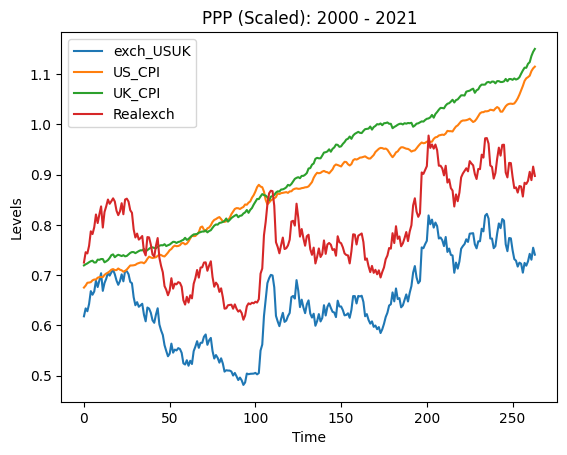

In [212]:
### Plot 1/exch_UKUS, US_CPI_col, UK_CPI_col, real exch rate: 2000 to 2021

time = range(len(exch_UKUS))  ### range(start, stop, step)

# plotting the points 
exch_USUK=1/exch_UKUS
realex=exch_USUK * US_CPI_col / UK_CPI_col

plt.plot(time, exch_USUK)
plt.plot(time, US_CPI_col/250)
plt.plot(time, UK_CPI_col/100)
plt.plot(time, realex/2)
#plt.xticks([2000,"","","","",2005,"","","","",2010,"","","","",2015,"","","","",2020,""])
# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Levels')
plt.legend(['exch_USUK','US_CPI','UK_CPI','Realexch'])  
# giving a title to my graph
plt.title('PPP (Scaled): 2000 - 2021')
  
# function to show the plot
plt.show()

In [213]:
### Transform exch rate and the CPIs to log forms
logexch=np.log(1/exch_UKUS) ### switch to pound per dollar
logUScpi=np.log(US_CPI_col)
logUKcpi=np.log(UK_CPI_col)

Now we perform Unit Root and Cointegration Tests for Monthly USD-Pound exch rate, US-CPI, and UK-CPI from 2000 to 2010

In [214]:
N_11yrs = 132
logexch1=logexch.iloc[0:N_11yrs,] ### 11 years monthly data from 2000 to 2010
logUScpi1=logUScpi[0:N_11yrs,]  ### Note logUScpi was constructed as numpy array - hence cannot use .iloc directly from pandas
logUKcpi1=logUScpi[0:N_11yrs,]
logr1 = logexch1 + logUScpi1 - logUKcpi1

In [215]:
### Unit Root Tests of ln(USD-UKP excange rate)
check_stationarity(logexch1)
Dlogexch1 = (logexch1.diff()).dropna()
check_stationarity(Dlogexch1)
### Unit Root Tests of ln(US_CPI)
check_stationarity(logUScpi1)
DlogUScpi1 = (np.diff(logUScpi1)) 
check_stationarity(DlogUScpi1)
### Unit Root Tests of ln(UK_CPI)
check_stationarity(logUScpi1)
DlogUKcpi1 = (np.diff(logUKcpi1))
check_stationarity(DlogUKcpi1)
### Unit root tests of log Real Exchange Rate in Pound per USD
check_stationarity(logr1)
Dlogr1 = (np.diff(logr1))
check_stationarity(Dlogr1)

ADF Statistic: -1.987442
p-value: 0.292106
The series is NOT stationary
ADF Statistic: -5.320925
p-value: 0.000005
The series is stationary
ADF Statistic: -0.806206
p-value: 0.817292
The series is NOT stationary
ADF Statistic: -7.409877
p-value: 0.000000
The series is stationary
ADF Statistic: -0.806206
p-value: 0.817292
The series is NOT stationary
ADF Statistic: -7.409877
p-value: 0.000000
The series is stationary
ADF Statistic: -1.987442
p-value: 0.292106
The series is NOT stationary
ADF Statistic: -5.320925
p-value: 0.000005
The series is stationary


Cointegration Tests for Monthly USD-Pound exch rate, US-CPI, and UK-CPI from 2011 to 2021

In [216]:
logexch2=logexch.iloc[N_11yrs+1:,]
logUScpi2=logUScpi[N_11yrs+1:,]  
### Note logUScpi was constructed as numpy array 
###  - hence cannot use .iloc directly from pandas
logUKcpi2=logUScpi[N_11yrs+1:,]
logr2 = logexch2 + logUScpi2 - logUKcpi2

In [217]:
### Unit Root Tests of ln(USD-USD excange rate)
check_stationarity(logexch2)
Dlogexch2 = (logexch2.diff()).dropna()
check_stationarity(Dlogexch2)
### Unit Root Tests of ln(US_CPI)
check_stationarity(logUScpi2)
DlogUScpi2 = (np.diff(logUScpi2)) 
check_stationarity(DlogUScpi2)
### Unit Root Tests of ln(UK_CPI)
check_stationarity(logUScpi2)
DlogUKcpi2 = (np.diff(logUKcpi2))
check_stationarity(DlogUKcpi2)
### Unit root tests of log Real Exchange Rate in Pound per USD
check_stationarity(logr2)
Dlogr2 = (np.diff(logr2))
check_stationarity(Dlogr2)

ADF Statistic: -1.577993
p-value: 0.494638
The series is NOT stationary
ADF Statistic: -12.854717
p-value: 0.000000
The series is stationary
ADF Statistic: 1.812866
p-value: 0.998374
The series is NOT stationary
ADF Statistic: -7.613445
p-value: 0.000000
The series is stationary
ADF Statistic: 1.812866
p-value: 0.998374
The series is NOT stationary
ADF Statistic: -7.613445
p-value: 0.000000
The series is stationary
ADF Statistic: -1.577993
p-value: 0.494638
The series is NOT stationary
ADF Statistic: -12.854717
p-value: 0.000000
The series is stationary


Johansen Cointegration Trace Stats Tests

In [218]:
# def Coint_test(list_of_data, const, lags):
PPP_coint_result =\
    Coint_test([logexch, logUScpi, logUKcpi], 0, 3)


In [219]:
### Using 3 lags. H_0: r=0 is not rejected. 
###  There appears to be no cointegration at 10% significance level.
print('Trace Stat:', 
      PPP_coint_result.trace_stat)               
# trace stats 
print('Critical Val:\n', 
      PPP_coint_result.trace_stat_crit_vals) 
# critical val [10%, 5%, 1%]

Trace Stat: [23.82659872  7.19131497  0.06727354]
Critical Val:
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [220]:
### Confirm using max eigenvalue test
print('Max Eigenvalue Stat:', 
      PPP_coint_result.max_eig_stat)               
# max eig stats [eiv1, eiv2, eiv3]
print('Critical Val:\n', 
      PPP_coint_result.max_eig_stat_crit_vals)          
# critical val [10%, 5%, 1%]

Max Eigenvalue Stat: [16.63528376  7.12404142  0.06727354]
Critical Val:
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
